_PyData Amsterdam 2017_

# From Fourier to Deep Convnets

### A.k.a. Signal Processing for Data Science

<hr>
Ivo Everts, Marcel Raas, Gabriele Modena
<hr>
https://github.com/godatadriven/pydata-2017-dsp-tutorial

### Introduction (45 min.)
- Signal processing applications
- Convolution
- Fourier analysis

### Feature engineering (50 min.)
- 1D signals: filter banks, pooling
- 2D signals: bag-of-words

### Break (15 min.)

### Feature learning (30 min.)
- PCA / LDA
- Convolutional neural network
    
### Speech processing hackathon (40 min.)
- Speaker / gender / age / nationality recognition...
- ...based on Fourier / bag-of-words / convnet

## About us

- Ivo Everts, Data Scientist at GoDataDriven, BSc+MSc+PhD in AI (biased to Computer Vision).

- Marcel Raas: Data Scientist at GoDataDriven, BSc+MSc+PhD in physics.

- Gabriele Modena: former collegue deserving kudos here not only because he is in the conference committee.

## Info

- This is a self-ish-contained notebook which is hereby offered to you (there is also environment.yml, util.py, images/ and data/). https://github.com/godatadriven/pydata-2017-dsp-tutorial
- Some machine learning knowledge is assumed
- ivoeverts@godatadriven.com

Copyright © 2017 GoDataDriven. All rights reserved.
Unless otherwise indicated, all materials on these pages are copyrighted by GoDataDriven. All rights reserved. No part of these pages, either text or image may be used for any purpose other than personal use. Therefore, reproduction, modification, storage in a retrieval system or retransmission, in any form or by any means, electronic, mechanical or otherwise, for reasons other than personal use, is strictly prohibited without prior written permission.

(but please use the code if you can;)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [156]:
import util, os, multiprocessing as mp
util.small_canvas_size(); util.figsize();
# viz
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec, mlab
%pylab inline
splot = subplot
# num
import pandas as pd
from scipy import signal, stats, ndimage
from sklearn import *

Populating the interactive namespace from numpy and matplotlib


## Introduction

- 'Traditional data' comes from the (relational) database in rows and columns
- Data is usually stored in a dataframe for processing, in Python, R, Spark, ...
- Columns typically represent clearly defined variables
- Apart from data cleaning and basic preprocessing, the data can be used as such by a machine learning algorithm, e.g. to predict income
<p>
```
id  age  gender  city  income
01   35       m   ams    NULL
02   20       m   rot   40000
03   20       f   rot   35000
04   40       f   ams   50000
..  ...  ......  ....  ......
```

### Nontraditional data	
- Non- (or at least less-) traditional data is e.g. text, speech, music, video, images, financial series, seismic waves, wifi/bluetooth counts, ...
- In a machine learning context, all those data have in common that they are *unstructured* and thus some sort of *feature extraction* needs to precede further processing

<center><img src=images/plot_ML_flow_chart_1.png width=70%></center>

### Applications

- Speech and music recognition in audio signals
    - [Voice recognition](https://www.microsoft.com/en-us/research/project/speaker-identification-whisperid/)
	- [Voice control](http://www.howtechnologywork.com/wp-content/uploads/2014/11/How-Siri-Technology-Work1.png)
    - [Content-based music search](http://www.shazam.com/company)
    
- Visual recognition in images and video
    - [Face recognition](https://www.facebook.com/facialrecognitionapp/)
    - [Crowd analysis](https://www.youtube.com/watch?v=7V8jrdH5tAQ)
	- [Content-based image and video search](http://techcrunch.com/2014/09/15/qualcomm-quietly-acquires-ai-based-image-recognition-startup-euvision/)
	- [Security](https://www.youtube.com/watch?v=Qx602tAsbX8)
    
- Smart meters
    - [Toon](https://www.eneco.nl/toon-thermostaat/?utm_source=google_dds-t&utm_medium=cpc&utm_campaign=01.00%20Eneco%20Toon%20-%20BR&utm_content=Toon%20-%20Exact&utm_term=toon&utm_device=c&gclid=CP7zzb2h79ECFeUV0wodl0cDHQ)
    - Decomposition of power usage
    
- Profit extraction from financial signals
    - [Forecasting stock market, currency exchange, credit rating, default probability, money laundering](http://www.fsplab.com/publications/4586238445)
    - [Financial network analysis](http://www.imf.org/external/pubs/ft/survey/so/2014/RES052314A.htm)

## Digital signal processing

A signal can broadly be viewed as a function

$$f(\mathbf{t}) \rightarrow \mathbf{v}$$ 
$$\mathbf{t} \in \mathcal{R}^N, \mathbf{v} \in \mathcal{R}^M.$$

Thus, mathematical operators can be applied to signals - this is already quite different from traditional data!

Usually, **t** denotes a step in time (i.e. *N=1*) and **v** is some scalar measurement at the moment of **t** (i.e. *M=1*). These are time series such as simple sensor measurements (temperature, humidity, seismic waves, people counts), financial transactions, etc. For e.g. images, **t** denotes image coordinates (row, column) and **v** is the (R,G,B) pixel value.

In [3]:
# some quasi-periodic function definition
def fn(t):
    return sin(t) + cos(t*2) + 2*random.rand(len(t))

In [4]:
def plot_f(f_data=None):
    if f_data is None:
        t = arange(31)
        v = fn(t)
    else:
        t = f_data[0]
        v = f_data[1]
    plot(t, v);
    util.xlabel('t'); util.ylabel('f(t)');

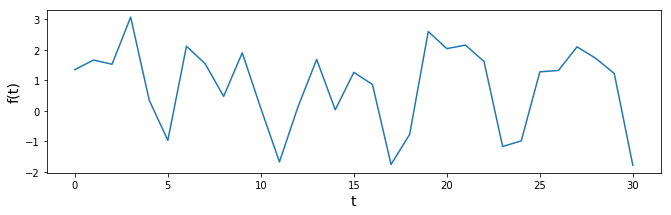

In [160]:
plot_f();

In order to represent this data for usage by a machine learning algorithm, we need to perform some sort of preprocessing and **feature extraction**.

In [6]:
def plot_inout_example():
    # time period (days) to consider
    ndays = 101

    # fraction of days on which a transaction occurs
    pos_prob = 1/1.1; neg_prob = 1/1.05

    # transactions
    pos = (random.rand(ndays) < pos_prob) *\
           abs(fn(arange(ndays))) / pos_prob
    neg = (random.rand(ndays) < neg_prob) *\
           abs(fn(arange(ndays))) / neg_prob
    cpn = cumsum(pos) - cumsum(neg)
    scpn = sort(cpn)

    # plot
    pos_nz = pos.nonzero()[0]
    neg_nz = neg.nonzero()[0]
    plot(pos_nz, pos[pos_nz], 'g*');
    plot(neg_nz, -neg[neg_nz], 'r*');
    plot(cpn, 'b-');
    plot([0, ndays-1], [scpn[-5], scpn[-5]], 'm:');
    util.legend(['in','out','cumulative','some threshold']);
    util.xlabel('day'); util.ylabel('amount');

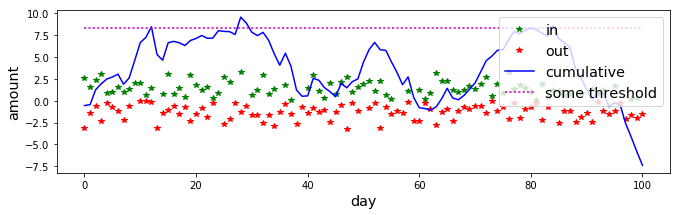

In [161]:
# example
plot_inout_example();

There are challenges due to noise and signal length; interesting features lie in the periodicity of the signal; this contrasts with simple global statistics such as max, mean.

### Convolution a.k.a. filtering

The preprocessing of and feature extraction from signals typically involves an operation called *convolution*, commonly denoted as $$(f * g)(t)$$ where *f* is our original function, and *g* is some other function.

Our data consists of a finite set of measurements at discrete steps, i.e. *samples*. This allows for a user-friendly mathematical notation of the convolution: $$(f*g)[\tau]=\sum_{t=-T}^T f[\tau-t]g[t].$$
<p>
<center><img src=images/1dconv.png></center>

#### Filtering with the Gaussian kernel

Probably the most common operation in signal processing is *smoothing* - which is achieved by convolving the signal _f_ with a (Gaussian) smoothing filter _g_. This can be used for noise reduction in e.g. audio signals, and blurring of images.

In [8]:
def plot_gaussian_convolution_example():
    t = np.arange(31); v = fn(t); g = signal.gaussian(3, 1);
    plot(t, v);
    plot(t, convolve(v, g/sum(g), 'same'));
    util.legend(['signal', 'smoothed signal']);
    util.title('Convolving a signal with a Gaussian kernel');
    util.xlabel('t'); util.ylabel('f(t)'); xlim(0, 30)

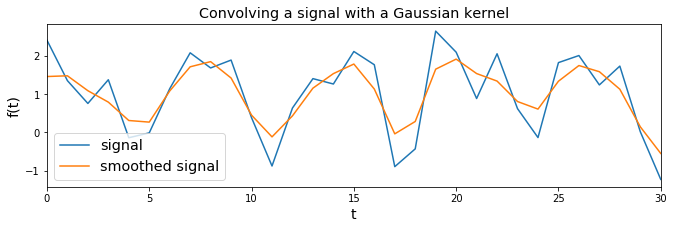

In [162]:
plot_gaussian_convolution_example()

In [10]:
def plot_gaussians():
    # parameters for data sampling with signal.gaussian
    num_samples, mean, std = 9, 0, 1
    
    # prevent insanity
    assert(num_samples % 2 == 1 and type(num_samples) == int)
    
    # define range, intentionally abusing the oddness and integerness of num_samples
    lb, hb = mean - num_samples/2, mean + num_samples/2
    
    # obtain a zero-mean 'gaussian window'
    g = signal.gaussian(num_samples, std)
    
    # obtain higher resolution samples to obtain 'the bell'
    sub_x = arange(lb, hb, .1)
    sub_g = stats.norm.pdf(sub_x, mean, std)
    
    # display a couple of gaussian flavours
    plot(arange(lb+.5, hb+.5), g);
    plot(sub_x, sub_g, 'b-');
    plot(sub_x, sub_g/max(sub_g), 'b.');
    util.legend(['signal.gaussian','stats.norm.pdf','scaled gaussian pdf']);

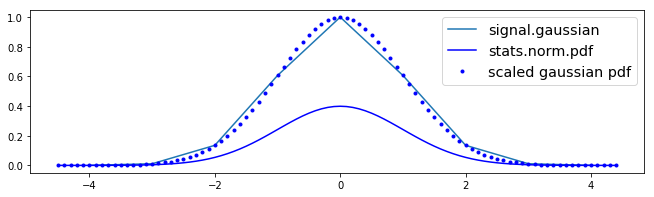

In [163]:
# Basically any numericish package/module/language
# has functionality for performing convolution 
# and associated kernel creation.
# It is an elementary operation for vector/matrix manupilation
# and thus relevant in particular to DSP.
plot_gaussians()

#### Multi-scale processing

The Gaussian kernel is parameterized by its standard deviation, so we can control that. 

In [12]:
# showcase filters of varying sizes
sigmas = append(0, power([0.5, 1, 2], 0.5));
def plot_multiscale_convolution_example():
    sub_x = arange(-5, 5, .1)
    t = arange(31); v = fn(t);
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
    for sigma in sigmas:
        splot(gs[0]).plot(sub_x, stats.norm.pdf(sub_x, 0, sigma))
        splot(gs[1]).plot(t, ndimage.filters.gaussian_filter(v, sigma))
    splot(gs[0]); axis([-5, 5, 0, 1.2]); util.title('Kernels')
    util.legend(['sigma = {:.2f}'.format(sigma) for sigma in sigmas])
    splot(gs[1]); util.title('Convolved signal')
    xlim(0, 30)

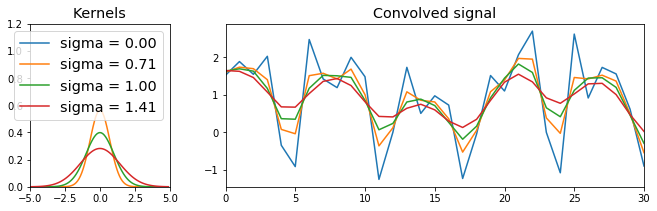

In [164]:
# go through the code
plot_multiscale_convolution_example()

#### Kernel density estimation

As an important side note of statistical nature: given the observed density below, how would convolution come in handy?

In [14]:
# throw in a function, reference global vars
# I'd rather be lazy than tired
def plot_gaussian_kde_example():
    # observe some random variable, sometimes
    observations = random.randn(341);
    # model the observations using a histogram
    counts, bins = histogram(observations, 21);
    # plot again for reference
    plot((bins[:-1]+bins[1:])/2, counts/float(sum(counts)));
    # kernel density estimation
    kernel = stats.gaussian_kde(observations)
    plot(bins, kernel(bins));
    plot(bins, kernel(bins)/sum(kernel(bins)));
    # the gaussian kernel
    kernel_tick = arange(-3, -1, .1)
    kernel_vals = stats.norm.pdf(kernel_tick, -2, sqrt(kernel.covariance[0][0]))
    plot(kernel_tick, kernel_vals/sum(kernel_vals))
    util.legend(['observations','unnormalized estimated density', 'estimated density', 'gaussian kernel'])

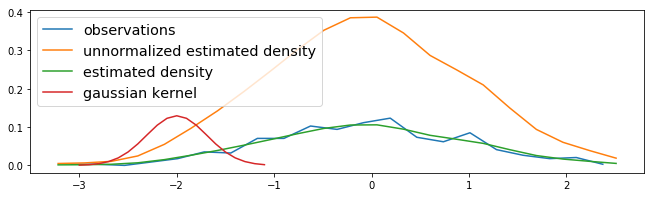

In [165]:
plot_gaussian_kde_example()

### Higher dimensions... images!

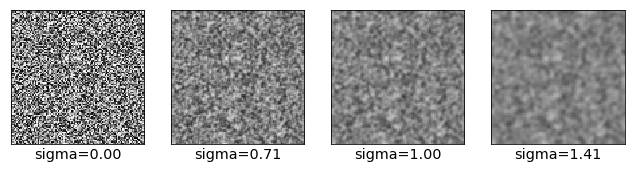

In [166]:
# example of smoothing a 2D signal - i.e. image blurring!
image = random.rand(100, 100)
for sigma, i in zip(sigmas, range(len(sigmas))):
    splot(1, len(sigmas), i+1);
    util.imshow(ndimage.filters.gaussian_filter(image, sigma));
    util.xlabel('sigma={:.2f}'.format(sigma))

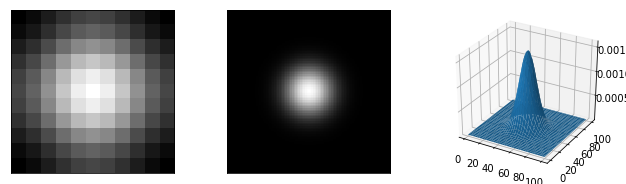

In [167]:
# couple of options for showing a 2D gaussian filter
splot(131);
image = zeros((11, 11));
image[5, 5] = 1;
util.imshow(util.imscale(
    ndimage.filters.gaussian_filter(image, 3)
))
splot(132);
x, y = meshgrid(range(101), range(101))
z = mlab.bivariate_normal(x, y, mux=50, muy=50, 
                                sigmax=10, sigmay=10)
util.imshow(util.imscale(z))
splot(133, projection='3d').plot_surface(x, y, z);

So, I guess you are starting to get those convolutional net imagery...!?

<img src="images/convolutional.jpg">

Besides smoothing, one of the most often used applications of convolution on images results in **edge detection**, which lies at the heart of many visual recognition systems.

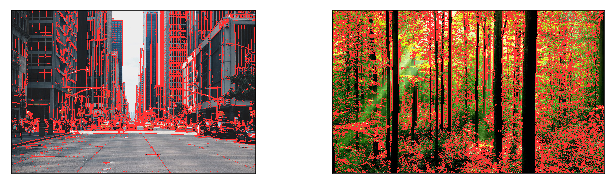

In [168]:
city = util.imread('city.jpg');
forest = util.imread('forest.jpg');
splot(121); util.imshow(util.detect_edges(city));
splot(122); util.imshow(util.detect_edges(forest));

In [19]:
# read one sample from 16 tiled mnist digits
def get_digit(digit=1, sub_idx=-1):
    # map between actual digits and (row, col) indices in the tiled digit image
    digit_idx = {0: [(0,1), (2,1)],
                 1: [(0,3), (2,3)],
                 3: [(1,0), (1,2), (3,0)],
                 4: [(0,2), (2,0)],
                 5: [(0,0)],
                 6: [(1,0), (1,3), (3,0)],
                 8: [(3,1)],
                 9: [(2,2), (3,3)]}
    assert(digit in digit_idx)
    # choose one of the available options
    assert(sub_idx < len(digit_idx[digit]))
    sub_idx = random.choice(len(digit_idx[digit])) if sub_idx < 0 else sub_idx
    idx = digit_idx[digit][sub_idx]
    # number of tiles (per dimension)
    ntiles = 4
    # read the digits
    tiles = util.imread('images/mnist_sample.png', 'F')
    # crop the requested tile
    height = tiles.shape[0] / ntiles
    width = tiles.shape[1] / ntiles
    return tiles[idx[0]*height:(idx[0]+1)*height, idx[1]*width:(idx[1]+1)*width]

Let's start with less complex images

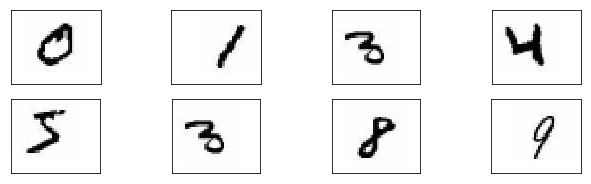

In [169]:
# not all digits are available in our mini sample
digits = [0,1,3,4,5,6,8,9]
for i in range(len(digits)):
    splot(2, 4, i+1);
    util.imshow(get_digit(digits[i]));

In [21]:
# plot the given image both on axes and on canvas
def hybrid_image_plot(im):
    util.figsize(16, 4)
    x, y = meshgrid(arange(im.shape[0]), arange(im.shape[1]), indexing='ij')
    fig = figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.view_init(80, 20)
    ax.plot_surface(x, y, im, cmap='Blues'); util.title('Image function')
    util.ylabel('column'); util.xlabel('row');
    fig.add_subplot(122)
    util.imshow(im); util.title('Image')
    util.figsize()

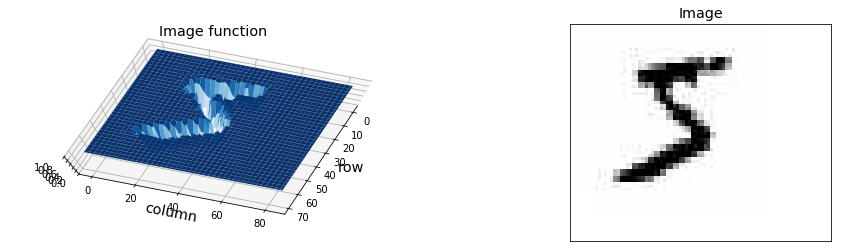

In [22]:
# now this should be fully understood (and appreciated;)
hybrid_image_plot(get_digit(5))

The image is just a 2D function $I = f(row, column), I \in [0, 255]$\*, so we can apply math to it.

\* a pixel is usually stored with 1 byte per channel, and converted to a float in [0,1] for ease of computation.

In [23]:
def show_image_derivatives(im):
    util.figsize(18, 3)
    splot(141); util.imshow(im); util.title('Image')
    splot(142); util.imshow(util.image_derivative(im, 'x')); util.title('dx')
    splot(143); util.imshow(util.image_derivative(im, 'y')); util.title('dy')
    splot(144); util.imshow(util.image_derivative(im, 'grad')); util.title('dx/dy')
    util.figsize()

Now we try to understand how edge detection works

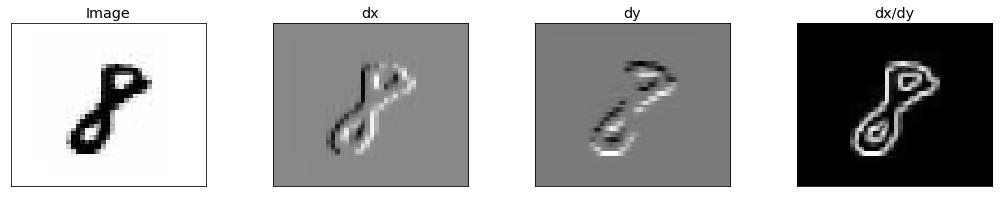

In [24]:
digit = get_digit(8)
show_image_derivatives(digit)

These images are created by convolving with a derivative filter. 
The image gradient is defined as the vector $[\delta_x, \delta_y]$. It's magnitude $\sqrt{{\delta_x}^2+{\delta_y}^2}$ corresponds to the amount of _contrast_; it's orientation $\arctan(\delta_y / \delta_x)$ corresponds to the _edge direction_.

A derivative filter: Sobel

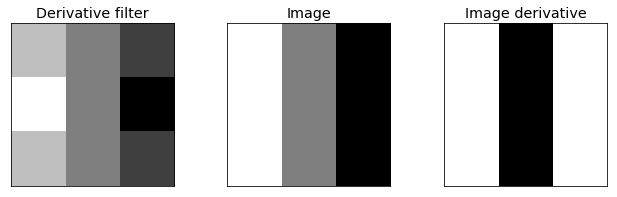

In [25]:
smoothing  = array([+1, +2, +1]).reshape(3,1)
derivative = array([+1,  0, -1]).reshape(1,3)
sobel_derivative = dot(smoothing, derivative)
splot(131);
util.imshow(util.imscale(sobel_derivative));
util.title('Derivative filter')
splot(132);
im = array([[1, 0.5, 0],[1, 0.5, 0],[1, 0.5, 0]])
util.imshow(im); util.title('Image')
splot(133);
util.imshow(util.imscale(
    ndimage.convolve(im, sobel_derivative
)));
util.title('Image derivative')

Now for *dy* as well

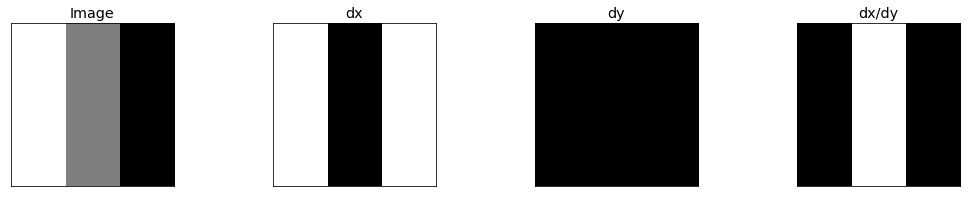

In [26]:
show_image_derivatives(im)

#### The Gaussian derivative filter

Convolving a signal with a Gaussian filter smooths the signal. Convolving a signal with a 'difference' filter like Sobel sort of differentiates the signal. Convolving a signal with a Gaussian derivative filter...

In [27]:
def show_gaussian_orders():
    pim = zeros((11,11));
    pim[5,5] = 1
    gaussian_orders = [ array([[0,0]]) ] + \
                      [ i*array([[1,0],[0,1],[1,1]]) for i in [1,2,3] ]
    nrows = len(gaussian_orders); ncols = max([len(l) for l in gaussian_orders]);
    nrow = 0;
    util.figsize(18,8)
    for i in range(nrows):
        nrow += 1; ncol = 0;
        for j in range(len(gaussian_orders[i])):
            ncol += 1
            splot(nrows, ncols, (nrow-1)*ncols+ncol);
            util.imshow(util.imscale(ndimage.gaussian_filter(pim, 1, order=gaussian_orders[i][j])))
            util.title(str(gaussian_orders[i][j]))
        ncol = 0;
    util.figsize()

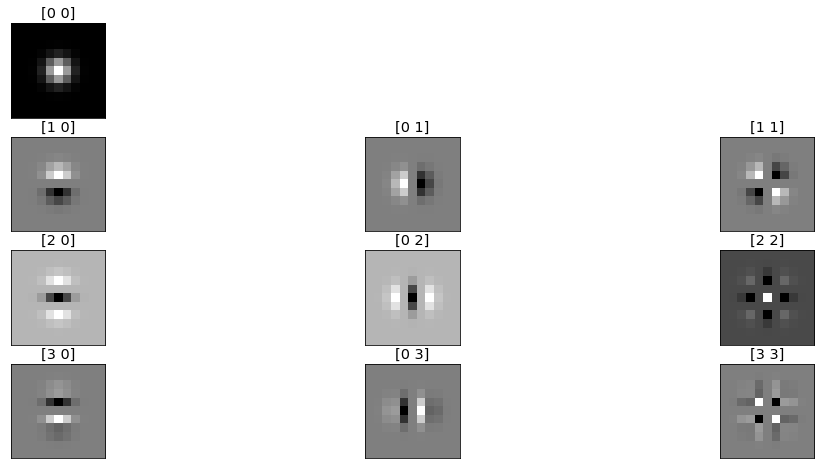

In [28]:
show_gaussian_orders()

In [29]:
def make_border_image(n = 100):
    bim = zeros((n, n), dtype='float')
    i, j = meshgrid(range(n), range(n), indexing='ij')
    # upper left quadrant
    bim[:n/2,:n/2] = 1
    # lower right quadrant
    bim[n/2:,n/2:] = 1
    # upper left circle
    bim[sqrt(i**2+j**2) < n/3] = 0
    # lower right circle
    bim[sqrt((n-i)**2+(n-j)**2) < n/3] = 0
    return bim

In [30]:
def show_gaussian_scale_orders(do_imscale=True, psychedelic=False):
    util.figsize(18, 6)
    if psychedelic:
        do_imscale = False
    bim = make_border_image()
    sigmas = power(2, arange(-1, 5.1, 2.))
    orders = [[0,0], [0,1]]
    i = 0
    for order in orders:
        for sigma in sigmas:
            g = ndimage.gaussian_filter(bim, sigma, order=order)
            if psychedelic:
                g = ndimage.convolve(bim, g)
            i += 1
            splot(3, 4, i)
            util.imshow(util.imscale(g) if do_imscale else g)
            util.title('s={:.1f}, o={}'.format(sigma, order))
    util.figsize()

Now we can extract multiscale differential features from images

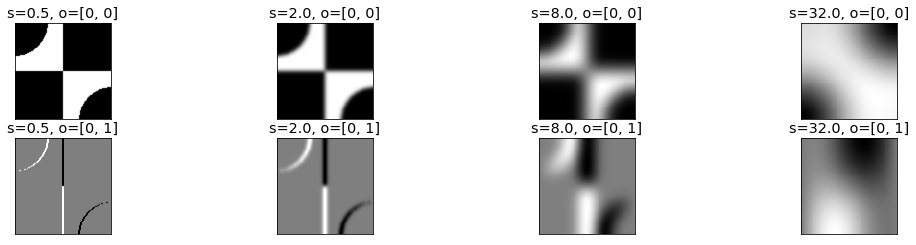

In [31]:
show_gaussian_scale_orders()

### Back to lower dimensions

We can do the same with 1D signals

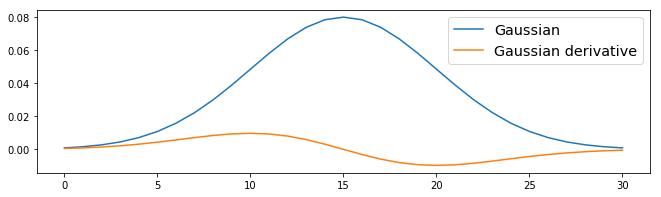

In [32]:
# finally, some custom code for a gaussian function ;)
def g(s=1, o=0, n=9):
    x = arange(n)-int(n/2)
    e = exp( - pow(x, 2) / (2*pow(s,2)) )
    p = sqrt(2 * pi)
    def g_0():
        return e / (s * p)
    def g_1():
        return -(e*x) / ( pow(s, 3) * p )
    return {0: g_0, 1: g_1}[o]()
plot(g(s=5,o=0,n=31)); plot(g(s=5,o=1,n=31));
util.legend(['Gaussian', 'Gaussian derivative'])

Sobel vs Gauss

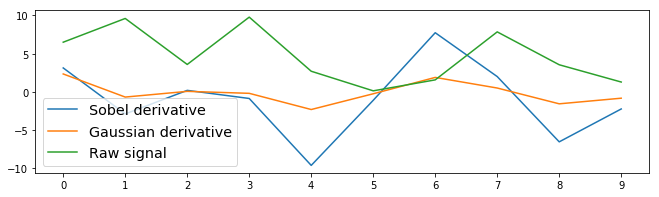

In [33]:
v = rand(10) * 10
# Raw Sobel filtering
plot(ndimage.filters.sobel(v))
# Gaussian derivative
plot(convolve(g(s=1,o=1,n=3), v, 'same'))
plot(v)
util.legend(['Sobel derivative',
             'Gaussian derivative',
             'Raw signal'])
xticks(range(len(v))); # so that we can see clearly...
util.figsize()

### Fourier analysis

Let's have a look at the following stock market graph:

<center><img src=images/rw-2-awr-random.png width=50%></center>

The graph looks quite random, but there seems to be a repeating pattern. How could we determine the periodicity?

We could smooth the signal (Gaussian smoothing with parameter $\sigma$) to get rid of most of the noise, followed by making a distribution of the distances of the $k$ nearest neighbours. The period will then hopefully be visible as a peak in this distribution.

#### Why use the Fourier transform?

The Fourier transformation will tell you how to break up a signal into signals that are periodic. You will get all frequencies/periods in your signal and it will tell you how much it contributes to the total as well!

Note: Let's not try to fully understand the math, but rather focus on the concepts and Python implementations.

Clearly it has an application in **sound data**, where the periodicity corresponds to the pitch of a sound, e.g. notes in music and intonation in speech.

<center><img src=images/music.png width=80%></center>

The signal can be extended to 2D data. So also image data can be decomposed into frequencies. 

This is for instance used in image compression, where the data for some frequencies that are not really important for the picture's perception is thrown away.

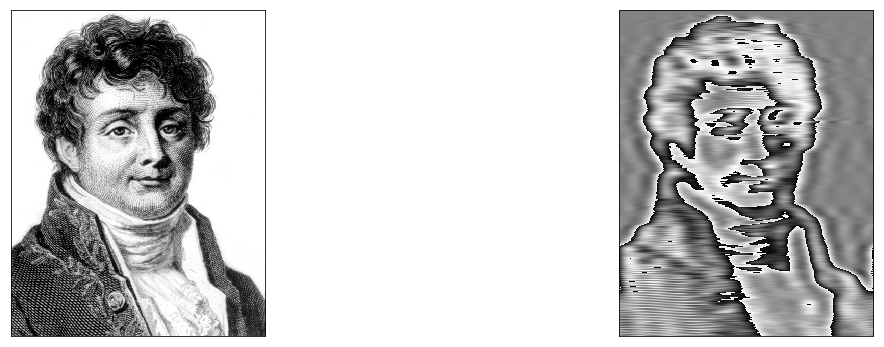

In [34]:
im = util.imread('images/jjfourier.jpg', edit_dir=True)
trans = fft.rfft2(im)
window_size = 10
trans[:, window_size:trans.shape[1]-window_size] = 0
util.image_subplots([im, fft.irfft2(-trans)])

#### How does it work? Approximately ;)

$Sinusoidal Wave = Amplitude * \sin(Frequency * Time + Phase)$

$f(t) = A \cdot \sin(2\pi{\cdot}f{\cdot}t + \phi)$

In [35]:
from IPython.display import HTML

In [36]:
# What happens when you add 2 harmonics
HTML('<iframe src=https://betterexplained.com/examples/fourier/?cycles=0,1,1 width=600 height=280></iframe>')

In [37]:
def add_harmonics(num, amp_harm_rel, numpoints=500):
    x = linspace(0, 2*pi, numpoints)
    out = zeros_like(x)
    harmonics = arange(num) + 1
    amps = amp_harm_rel(harmonics)
    for harm, amp in zip(harmonics, amps):
        out += amp * sin(x * harm)
    return out

def square_wave(x, T):
    return sign(sin(2*pi*x/T))
    
def b_n(n):
    n = int(n)
    if (n%2 != 0):
        return 4/(np.pi*n)
    else:
        return 0

def w_n(n):
    T = 8
    wn = (2*pi*n)/T
    return wn

def fourier_series(max_n, x):
    a_0 = 0
    sums = a_0
    for n in range(1,max_n):
        sums += b_n(n) * np.sin(w_n(n)*x)
        
    return sums

X = linspace(-20,20,10000)
y = []
for x in X:
    y.append(square_wave(x, T=8))

f = []
for i in X: 
    f.append(fourier_series(20, i))

Any function can be written as a sum of harmonics

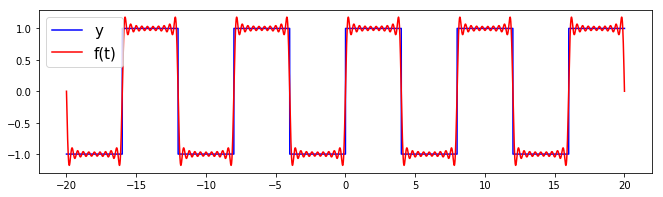

In [38]:
plot(X, y, color="blue", label="y")
plot(X, f, color="red", label="f(t)")
legend(fontsize=15, loc='upper left');

A.k.a. the Fourier series $$f(t) = a_0 + \sum_{n=1}^\infty [a_n \cos(\omega_n t) + b_n \sin(\omega_n t)]$$

#### The Discrete Fourier Transform

$$F_k = \frac{1}{N} \sum_{n=0}^{N-1}{f_n e^\frac{-2 i \pi n k}{N}}$$

where:
 * N is the number of samples in the time domain
 * $F_k$ is the DFT for frequency $k$
 * $k$ is the frequency 
 * $f_n$ is the value of the signal at time $n$
 
And mr. Euler came up with this: $e^{i \varphi} = \cos \varphi + i \sin \varphi$ so we see the relationship between complex exponentials and harmonic functions.

The discrete Fourier transform of a real sequence of numbers will be a sequence of complex numbers of the same length

### Working with FFT in python

In [39]:
def fft_plot(x_data, f_data):
    splot(121); plot(x_data[0], x_data[1]);
    title('Signal');util.xlabel('time'); util.ylabel('amplitude');
    splot(122); plot(f_data[0], f_data[1]);
    title('Real part - positive frequencies'); util.xlabel('freq'); util.ylabel('amplitude');

def add_gaussian_noise(X, mu=0, sigma=1):
    noise = [random.normal(mu, sigma) for _ in range(len(X))]
    return [s + n for s, n in zip(X, noise)]

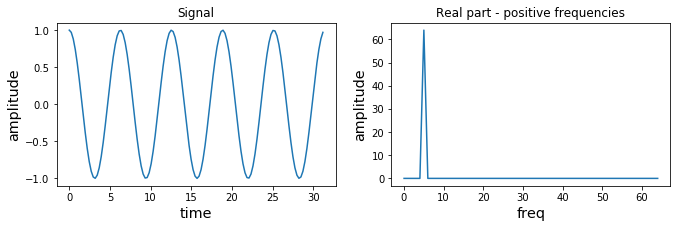

In [40]:
frequency = 5.0
phs = np.linspace(0, frequency * 2 * pi, 128, endpoint=False)
X = cos(phs)
fft_bins = rfftfreq(len(X), d=1/float(len(X)))
F = real(fft.rfft(X))
fft_plot((phs, X), (fft_bins, F))

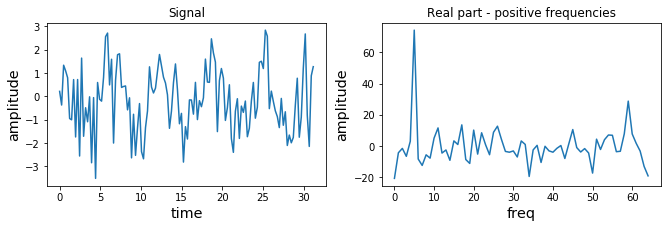

In [41]:
noisy_X = add_gaussian_noise(X)
noisy_F = real(fft.rfft(noisy_X))
fft_plot((phs, noisy_X), (fft_bins, noisy_F))

In [42]:
from scipy.signal import gaussian

In [43]:
def plot_convolution_result(g, t, v):
    plot(t, v)
    plot(t, convolve(v, g/sum(g), 'same'))
    legend(['signal', 'smoothed signal'])
    title('Convolving a signal with a Gaussian kernel')
    xlabel('t'); ylabel('f(t)');

### The Convolution Theorem

Recall: a signal can smoothed by convolving with a Gaussian filter.

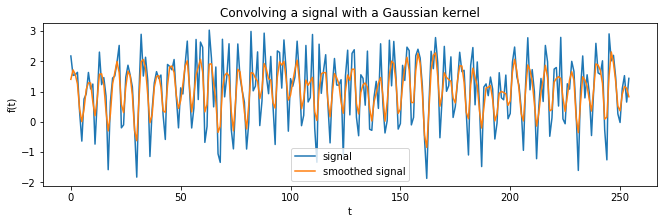

In [44]:
def f(t):
    return sin(t) + cos(t*2) + 2*random.rand(len(t))

g = gaussian(3, 1)
t = arange(255)
v = f(t)
plot_convolution_result(g, t, v)

We can determine the frequencies in the signal by using the Fourier transform.

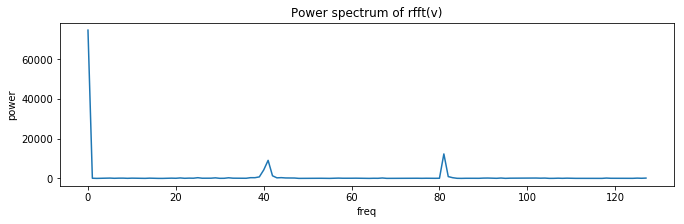

In [45]:
freq = rfftfreq(len(t), d=1/float(len(t)))
power_spectrum = absolute(fft.rfft(v))**2
idx = argsort(freq)
plot(freq[idx], power_spectrum[idx]);
title('Power spectrum of rfft(v)')
xlabel('freq'); ylabel('power');

In [46]:
window =  g/sum(g)
convolved = convolve(v, window, 'same')
power_spectrum_convolved = absolute(fft.rfft(convolved))**2
idx = argsort(freq)

Now let's look at the power spectrum of the convolved signal.

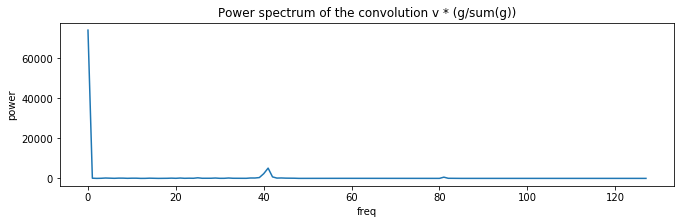

In [47]:
plot(freq[idx], power_spectrum_convolved[idx]);
title('Power spectrum of the convolution v * (g/sum(g))')
xlabel('freq'); ylabel('power');

As expected, the high frequencies are attenuated after smoothing the signal.

In [48]:
N = (len(t)-len(window)) / 2
padded = pad(window, int(N), 'constant', constant_values=0)
dft_window = fft.rfft(padded)
power_spectrum_window = absolute(dft_window)**2
idx = argsort(freq)

Now let's look at the power spectrum of the Gaussian filter

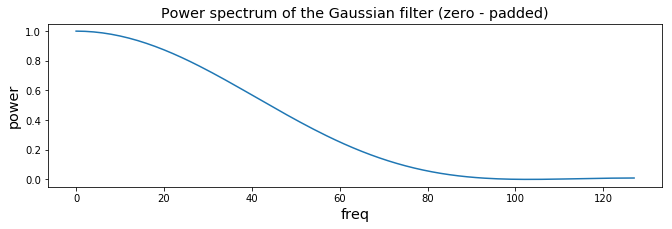

In [49]:
plot(freq[idx], power_spectrum_window[idx]);
util.title('Power spectrum of the Gaussian filter (zero - padded)')
util.xlabel('freq'); util.ylabel('power');

And finally: the product of the spectra of the filter and the original signal.

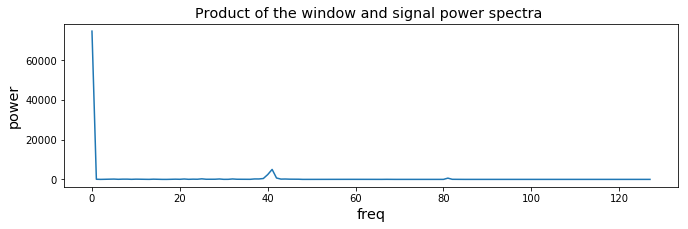

In [50]:
prod = power_spectrum_window * power_spectrum
plot(freq[idx], prod[idx]);
util.title('Product of the window and signal power spectra ')
util.xlabel('freq'); util.ylabel('power');

What the F!? This looks exactly the same as the spectrum of the filtered signal. Could this be a theorem?

The Convolution Theorem says that given two functions $f$ and $g$:

$$ \mathrm{FT}(f * g) = \mathrm{FT}(f) \cdot \mathrm{FT}(g). $$

Meaning that **convolution in the time domain is equivalent to multiplication in the frequency domain**.

The FFT is applied on speech data in the last section of this tutorial.

## Feature engineering

Why are we not always using the Fourier Transform for representing signals? Come on, think about it: with the FT we can represent any signal _precisely_!

> This is a classic: as opposed to precisely modelling the data, we nowadays collect examples and extract features for representing that data in a statistical formulation of the problem. A.k.a. machine learning.

#### Invariance

Let's think about factors in the process of signal measurement against which the representation should be invariant.

- Background noise in audio
    - Cocktail party
- Illumination conditions in an image
    - Shadow, shading, highlights
- ...

<center><img src=images/color_derivatives.png width=800></center>

In feature extraction for machine learning, we aim to find the optimal trade-off between *discriminative power* and *invariance*.

- what is the most discriminative representation of a signal?

- what is the most invariant representation of a signal?

- what is other common terminology to denote this phenomenon?

<center><img src=images/abstraction.png width=600></center>

- what is the most discriminative representation of a signal?
    - the raw signal itself
- what is the most invariant representation of a signal?
    - a representation that is always the same, independent of the signal
- what is other common terminology to denote this phenomenon?
    - bias/variance tradeoff

### Feature extraction using filter banks

We can represent a signal by it's impuls response to a set of filters, commonly refered to as a *filter bank*. The filters are designed such that a signal's space/time and frequency characteristics are adequately measured.

> A filter response represents the similarity between the signal and the filter, while no explicit assumptions are being made about the underlying data-generating process. This generally results in robust representations.

In [51]:
def plot_signals(signals, labels):
    util.figsize(16, 6)
    nl = []
    for label in util.data_labels.keys():
        signals2 = signals[labels==label]
        nl.append(signals2.shape[0])
        maxi = min(6, len(signals2))
        for i in range(maxi):
            splot(2,3,i+1)
            plot(signals2[i])
    splot(2,3,1);
    util.legend(['{} ({})'.format(s,n) for (s,n) in zip(util.data_labels.values(), nl)])
    util.figsize()

So let's have a look, and get some data first. We'll stick with 1 dimension for now.

660 samples


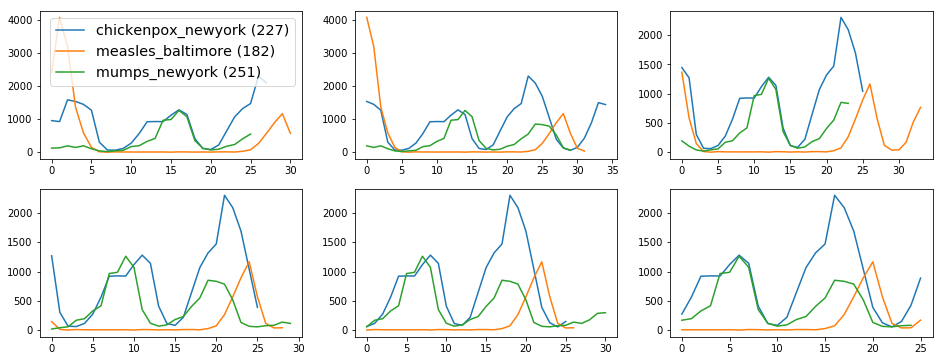

In [52]:
signals, labels = util.make_datamarket_health_dataset()
plot_signals(signals, labels)
print('{} samples'.format(len(signals)))

Interesting properties of these data are: min, max, mean, periodicity, ... So we should choose appropriate filters and extract features by convolution.

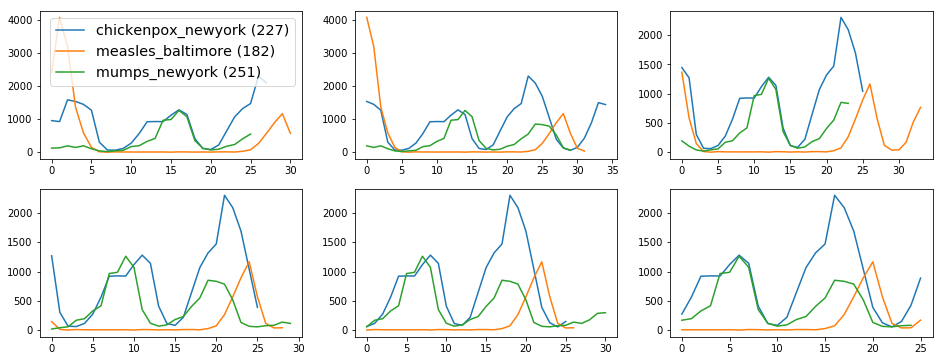

In [53]:
plot_signals(signals, labels)

#### Gabor filters

A popular filter for capturing space/time/frequency characteristics is the *Gabor filter*. These are mostly well-known in image processing but generally apply to signals of any dimension.

The Gabor transform is one of many so called band pass filters that allows you to 'cut' the Fourier transform and isolate only specific information.

This is rather complex, but in the following we'll just assume that a Gabor filter is basically a sinusoid multiplied by a Gaussian, with which we can do cool stuff.

In [54]:
def plot_filter(f):
    plot(range(len(f)), f);
    xlim((0,len(f)))
    util.no_ticks()

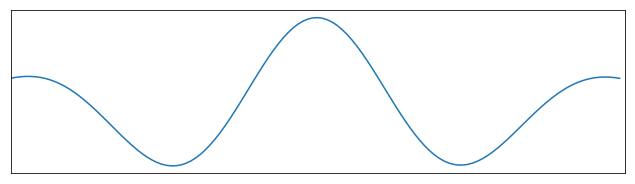

In [55]:
# create a gabor filter based on 
#   a gaussian with std s and 
#   a sinusoid with frequency f
def make_gabor_filter(s, f, sample_rate=None):
    sample_rate = s/10 if sample_rate is None else sample_rate
    t = arange(-s, +s, sample_rate)
    A = 1; p = 0;
    sinusoid = A * np.cos(f * t + p)
    gaussian = signal.gaussian(len(t), s**2)
    return sinusoid * gaussian

plot_filter(make_gabor_filter(pi/.5, 1, 0.1));

In [56]:
# subplot arrangement for filter bank visualization
# by default fine grained sampling for visualization
def plot_gabor_filter_bank(params, sample_rate=0.1):
    util.figsize(14,6)
    num_s = len(unique(params[:,0]))
    num_f = len(unique(params[:,1]))
    fb = make_gabor_filter_bank(params, sample_rate)
    for i in range(len(fb)):
        splot(num_s, num_f, i+1)
        plot_filter(fb[i])
        util.title('std={:.2f}, freq={:.2f}'.format(params[i,0], params[i,1]))
    util.figsize()

Now create a *filter bank* by considering a set of parameters for constructing Gabor filters

In [57]:
# create a filter bank from the given set of parameters
def make_gabor_filter_bank(params, sample_rate=1):
    return [make_gabor_filter(s, f, sample_rate) \
            for (s,f) in params]

# make a sensible set of parameters for filter bank construction
def get_gabor_filter_bank_params(
        # default parameter set
        std = arange(pi/2, pi/.5, pi/2),
        freq = arange(1, 4, 1)):
    # joint parameter set
    x, y = meshgrid(std, freq)
    return array([x.flatten(), y.flatten()]).T

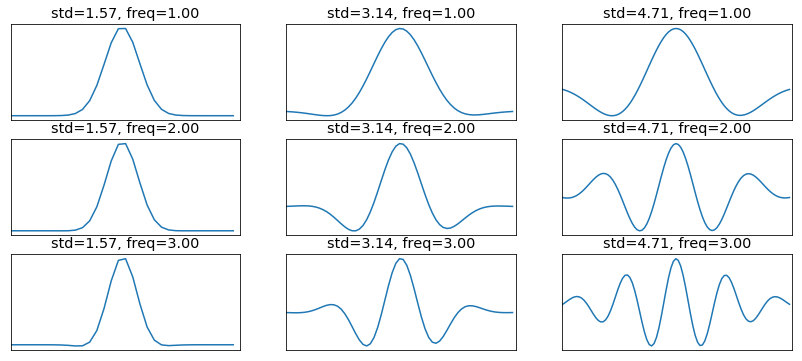

In [58]:
plot_gabor_filter_bank(get_gabor_filter_bank_params())

### Signal classification using filter banks

Let's move on to a classification round using filter banks: which signal represents which disease?

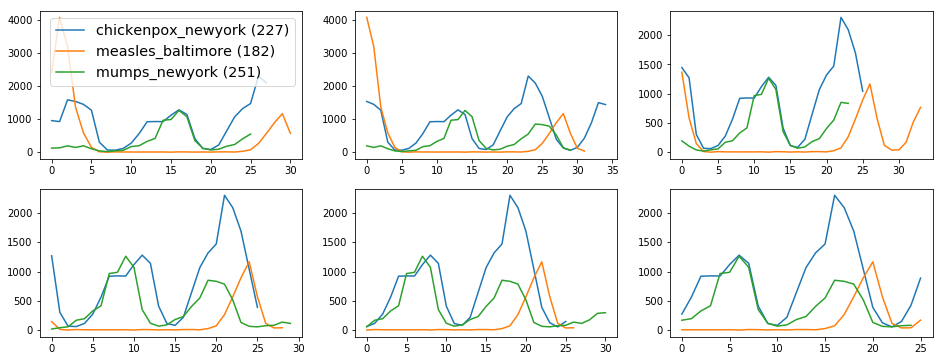

In [59]:
plot_signals(signals, labels);

For constructing fixed-length feature vectors, we need to convolve the signal and aggregate the filter response using some aggregator. This is know as _Feature Pooling_.

In [60]:
# default feature aggregation, a.k.a. pooling
default_feature_aggregators = [mean, std, max]

# apply a given set of functions the the given data
def apply_all(x, fs):
    return array([f(x) for f in fs])

# apply a filterbank to a signal
# and extract features using the provided aggregators
def apply_filter_bank(v, fb, aggregators):
    fb_result = [apply_all(np.convolve(v, f, 'valid'),\
                           aggregators)\
                 for f in fb]
    return array(fb_result).flatten()

For each of the 9 filters, we pool the result with a mean, std and max aggregator. This yields 27 numbers.

In [61]:
# build the filter bank
gabor_params = get_gabor_filter_bank_params()
fb = make_gabor_filter_bank(gabor_params)

# apply the filter bank to a signal
apply_filter_bank(signals[0], fb, default_feature_aggregators)

array([ 1495.23176041,   939.92067101,  3367.1978114 ,  -551.52858247,
        1014.9391915 ,  1443.31771911, -1694.35771167,  1292.39585964,
         296.61427513,  -484.51676414,   300.38765524,    50.11674388,
         567.52926912,   430.0839714 ,  1560.15736545,  -547.93679011,
         525.11152748,   336.15900611,  -164.65933555,   108.19364065,
         -22.36140403,  -593.83879869,   312.31241484,  -145.02812401,
         446.11985246,   285.7219919 ,  1035.56172359])

Train and test the features.

In [62]:
# apply the filterbank to all signals
def extract_gabor_features(signals, fb, aggregators):
    return array([apply_filter_bank(signal, fb, aggregators)\
                  for signal in signals])

gabor_features = extract_gabor_features(
                    signals, fb, default_feature_aggregators)
gabor_features.shape

(660, 27)

In [63]:
# leave-one-out classification round with gabor features
result1 = util.l1o_model_validation(gabor_features, labels)
print('gabor features l1o: {:.0f}%'.format(100*result1))

gabor features l1o: 99%


Note: it is not said that this is the best approach with the best parameters for this problem, but we've come a long way in 1 try ;)

Also note that usually *max-pooling* results in the most discriminative representation.

In [64]:
# store the 1D gabor features for later usage
save('data/feats1D.npy', 
     hstack([gabor_features, labels.reshape((len(labels),1))]));

### 2D Gabor filter banks: extracting image texture

In [65]:
# gabor kernels are readily available in scikit-image
from skimage.filters import gabor_kernel

In [66]:
def get_gabor_kernels(return_params=False):
    kernels = []
    params = []
    for theta in range(4): # hey now we can rotate the filter as well!
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernels.append(gabor_kernel(frequency, theta=theta,
                                            sigma_x=sigma, sigma_y=sigma))
                params.append((round(theta,2), sigma, frequency))
    if return_params:
        return kernels, params
    return kernels

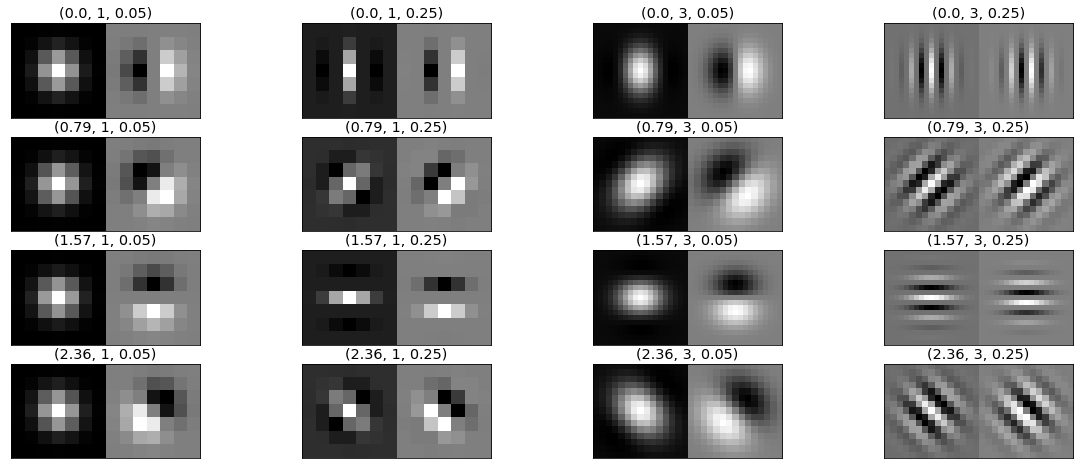

In [67]:
# prepare filter bank kernels
util.figsize(20, 8)
kernels, params = get_gabor_kernels(True)
for i in range(len(kernels)):
    splot(4, 4, i+1); # 16 kernels assumed
    util.imshow(hstack([util.imscale(real(kernels[i])), 
                        util.imscale(imag(kernels[i]))]))
    util.title(params[i])
util.figsize()

Let's extract Gabor features from an image...

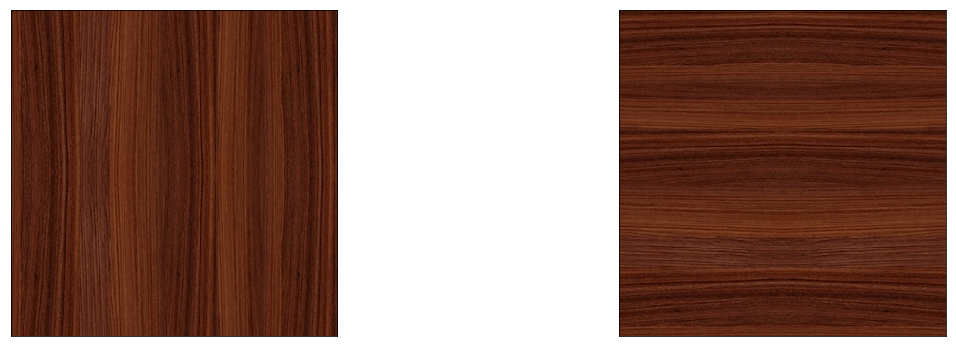

In [68]:
wood1 = util.imread('images/vertical_wood.jpg');
wood2 = util.imread('images/horizontal_wood.jpg');
util.image_subplots([wood1, wood2])

In [69]:
def kernel_power(image, kernel):
    image = (image - image.mean()) / image.std()
    return sqrt(ndimage.convolve(image, real(kernel), mode='wrap')**2 +
                ndimage.convolve(image, imag(kernel), mode='wrap')**2)

def compute_kernel_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=double)
    for k, kernel in enumerate(kernels):
        filtered = kernel_power(image, kernel)
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats
            
def plot_feat_hists(h1, h2):
    r = arange(len(h1))
    bar(r+0.00, h1[:,0], width=0.4);
    bar(r+0.40, h2[:,0], width=0.4);
    xticks(r)

...and look how they represent the image content.

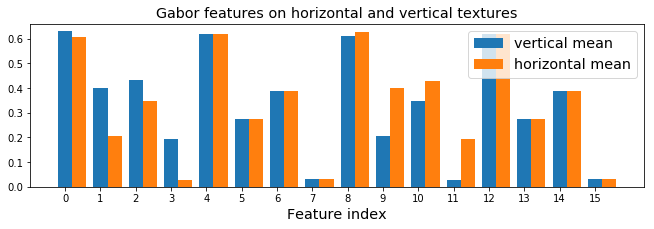

In [70]:
wood1_gabor_feats = compute_kernel_feats(mean(wood1, axis=2),
                                         kernels)
wood2_gabor_feats = compute_kernel_feats(mean(wood2, axis=2),
                                         kernels)
plot_feat_hists(wood1_gabor_feats, wood2_gabor_feats)
util.legend(['vertical mean','horizontal mean'])
util.xlabel('Feature index')
util.title('Gabor features on horizontal and vertical textures')

In [71]:
def compute_local_kernel_feats(image, kernels,
                               sample_rate=6, patch_size=24,
                               aggregators=[mean],
                               descriptors_only=True):
    
    # apply convolution with all provided kernels
    fstack = zeros((image.shape[0], image.shape[1], len(kernels)))
    for i, kernel in enumerate(kernels):
        fstack[:,:,i] = kernel_power(image, kernel)
    
    # naive implementation of grid-based feature sampling
    hsize = int(patch_size/2)
    rrange = range(hsize, image.shape[0]-hsize, sample_rate)
    crange = range(hsize, image.shape[1]-hsize, sample_rate)
    num_feats = len(rrange) * len(crange)
    feats = zeros((num_feats, fstack.shape[2] * len(aggregators)))
    locs = zeros((num_feats, 3))
    c = 0
    for i in rrange:
        for j in crange:
            f = fstack[i-hsize:i+hsize, j-hsize:j+hsize, :]
            for k, agg in enumerate(aggregators):
                kstart = k * fstack.shape[2]
                kend = (k+1) * fstack.shape[2]
                feats[c, kstart:kend] = agg(agg(f, axis=0), axis=0)
            locs[c, :] = [i, j, hsize]
            c += 1
    
    if descriptors_only:
        return feats
    return hstack([locs, feats])

# loc contains y,x,scale; use that to extract a patch from the given image
def get_patch(im, loc, zoom=20):
    # scale multiplier for patch extraction
    scale_mag = zoom * loc[2]
    # row range
    row_min = max(0, int(loc[0]-scale_mag))
    row_max = min(im.shape[0], int(loc[0]+scale_mag+1))
    col_min = max(0, int(loc[1]-scale_mag))
    col_max = min(im.shape[1], int(loc[1]+scale_mag+1))
    return im[arange(row_min, row_max),:][:,arange(col_min, col_max)]

#### Constructing a visual vocabulary with Gabor features

Here, we'll see the concept of creating a visual vocabulary from local features that can be used for constructing bag-of-visual-words image representations. Then, this model will be applied to a bunch of images from cats and dogs using another type of popular image feature (SIFT) - which has dominated the computer vision literature between Fourier and Deep learning (roughly;).

Extract local features from an image

(16068, 16)

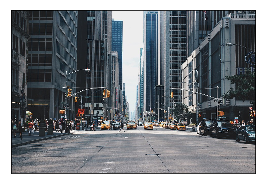

In [264]:
local_gabor_features = compute_local_kernel_feats(
                            mean(city, axis=2),
                            kernels,
                            descriptors_only=False)
locs = local_gabor_features[:, :3]
feats = preprocessing.StandardScaler().\
            fit_transform(local_gabor_features[:, 3:])
util.imshow(city)
feats.shape

Compute bag-of-visual-words image descriptor

In [265]:
# do clustering of the features to construct 10 visual words
k = 10
gabor_vocab = cluster.KMeans(k).fit(feats)

# map the gabor features to their 'prototypes'
p = gabor_vocab.predict(feats)
image_descriptor = histogram(p, bins=k)[0]

# create the bovw descriptor: the distribution of local features over visual words
image_descriptor / sum(image_descriptor)

array([ 0.09366443,  0.04288026,  0.24166044,  0.06198656,  0.05072193,
        0.11426438,  0.05146876,  0.21521036,  0.0238362 ,  0.1043067 ])

Visualize a bunch of image patches that have been mapped to the same visual word.

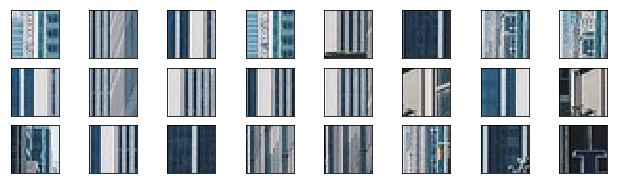

In [275]:
word_nr = 6
l = random.permutation(locs[p==word_nr])
for i in range(len(l)):
    if i < 24:
        splot(3, 8, i+1)
        util.imshow(get_patch(city, l[i], zoom=1))

Now the same vocabulary can be used for representing any other image

(900, 16)

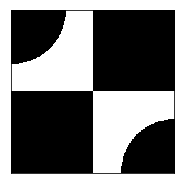

In [273]:
bim = make_border_image(200)
bim_gabor_feats = compute_local_kernel_feats(
                        bim, kernels, descriptors_only=False)
bim_locs = bim_gabor_feats[:, :3]
bim_feats = preprocessing.StandardScaler().\
                fit_transform(bim_gabor_feats[:, 3:])
util.imshow(bim)
bim_feats.shape

And we can see that similar structures are mapped to the same word

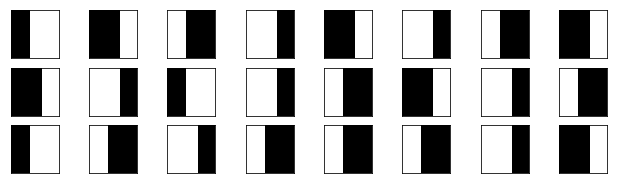

In [276]:
bim_p = gabor_vocab.predict(bim_feats)
bim_l = random.permutation(bim_locs[bim_p==word_nr])
for i in range(len(bim_l)):
    if i < 24:
        splot(3, 8, i+1)
        util.imshow(get_patch(bim, bim_l[i], zoom=1))

And maybe [this 3D Gabor application](https://www.youtube.com/watch?v=nNkL0fkTOjQ) is a nice way to conclude the Gabor stuff.

### Visual recognition with bags-of-visual-words

Before the rise of deep learning with convolutional neural networks, the status quo in computer vision was constituted by the bag-of-visual-words model. This model involves 1) adequately representing _local_ image features 2) constructing a visual vocabulary for vector quantizing the feature vectors and 3) training a classifier with the image features and associated labels (e.g. dog, cat). In the following we'll touch on the aspects involved.

For this occasion, I have hidden most of the code and I will skip the details because at the end of the tutorial I recommend you pip install Keras anyway ;)

#### BOVW 1) Representing image features

Probably the most cited article in computer vision is David Lowe's paper on [SIFT](https://computervisionblog.wordpress.com/2012/02/10/the-most-cited-papers-in-computer-vision/): the Scale Invariant Feature Transform. These are local image features that have dominated computer vision, and are typically better suitable for general vision problems than Gabor features.

There's quite a lot to it - here we'll just mention the Feature Transform part: it uses features based on the image gradient, which we saw earlier in the tutorial. But scroll through [the paper](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for the fun of it. 

Note the importance of _local_ features for robustness against geometric distortions due to scale, rotation, viewpoint and occlusion.

Let's just extract local image features using Mahotas, as that came up as easy and free to use - SIFT is patented and Mahotas provides a convienent lib for extracting a fast approximation called [SURF](http://www.vision.ee.ethz.ch/~surf/eccv06.pdf) (elected in 2016 as ECCV's best paper of 10 years ago).

In [77]:
# import surf from Mahotas
from mahotas.features import surf

ucity = util.float3d_to_uint2d(city)
uforest = util.float3d_to_uint2d(forest)

# detect feature locations and extract feature vectors
# let's not worry about all the possible parameter settings
city_features = surf.surf(ucity)
forest_features = surf.surf(uforest)

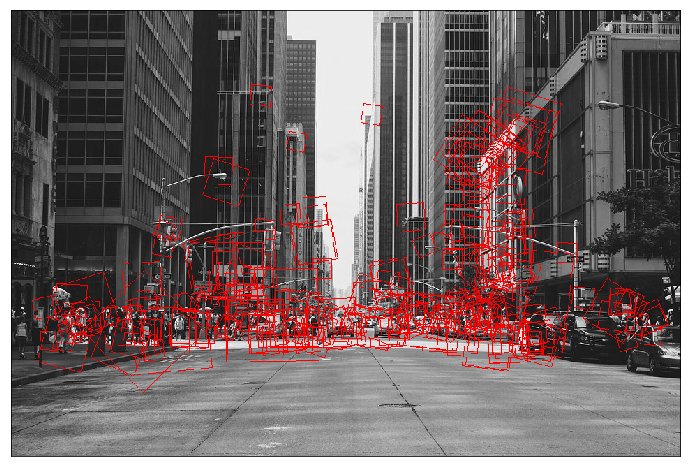

In [78]:
# Plotting the local features on the image canvas,
# we can see the different scales and orientations.
util.figsize(12, 12)
util.imshow(surf.show_surf(ucity, city_features[:250]))
util.figsize()

#### BOVW 2) Representing image features

So now that we have a way to extract robust local features, we can proceed by learning the visual vocabulary. For this, we'll use dogs and cats.

In [179]:
# obtain filepaths and labels
label_dict = {'cat': 0, 'dog': 1}
data_dir = 'data/cat_dog/';
filenames = os.listdir(data_dir)
filepaths = []; labels = []
for filename in filenames:
    if filename.endswith('jpg'):
        filepaths.append(data_dir+filename)
        labels.append(label_dict[filename[:3]])
labels = array(labels)

In [80]:
print(len(labels), 'files,',
      sum(labels), 'dogs,',
      len(labels)-sum(labels), 'cats')

100 files, 50 dogs, 50 cats


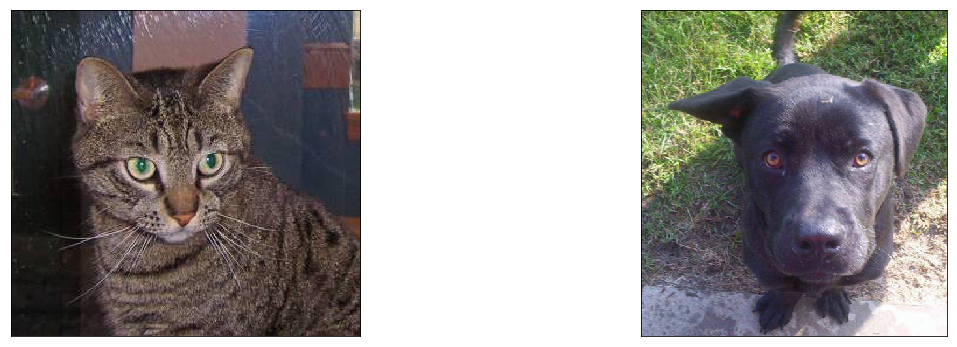

In [81]:
util.image_subplots([util.imread(filepaths[1], edit_dir=False),
                     util.imread(filepaths[-2], edit_dir=False)])

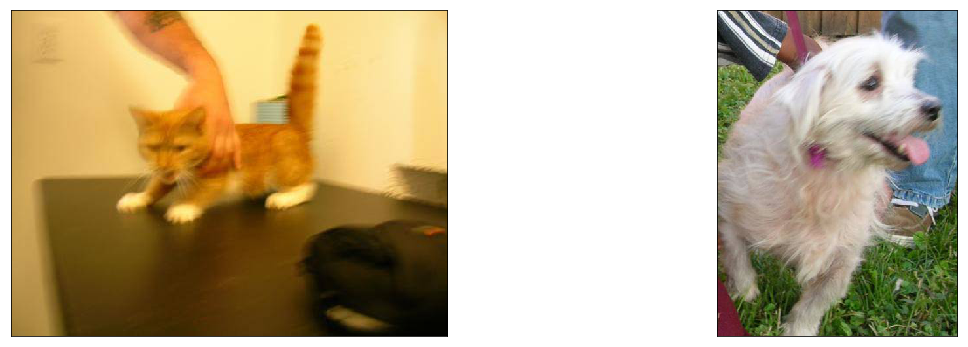

In [82]:
util.image_subplots([util.imread(filepaths[0], edit_dir=False),
                     util.imread(filepaths[-1], edit_dir=False)])

That looks like a pretty hard problem

We'll be extracting dense features, because that usually performs better than sampling from keypoints (more=more). And, in addition to that, in this lecture we're using only 100 images but we need enough data to be able to construct the visual vocabulary.

In [176]:
# we don't want to be storing images and features, 
# so use a filepath for feature extraction
def extract_surf_features(filepath, num_feats=None, descriptors_only=True):
    im = util.float3d_to_uint2d(util.imread(filepath, edit_dir=False))
    feats = surf.dense(im, 4, scale=1, include_interest_point=not descriptors_only);
    if num_feats is not None and num_feats < feats.shape[0]:
        return feats[random.permutation(range(feats.shape[0]))[:num_feats]]
    return feats

# we can have different numbers of descriptors, with or without location/scale/orientation
for fp, b in zip([filepaths[0], filepaths[-1]], [True, False]):
    print(extract_surf_features(fp, descriptors_only=b).shape, fp)

(10062, 64) data/cat_dog/cat.0.jpg
(9828, 70) data/cat_dog/dog.9.jpg


In [238]:
# function for creating the visual vocabulary
def create_visual_vocabulary(filepaths, k, num_features_for_clustering=10000):
    num_features_per_file = int(num_features_for_clustering / len(filepaths))
    all_feats = None
    for filepath in filepaths:
        feats = extract_surf_features(filepath, num_feats=num_features_per_file)
        if all_feats is None:
            all_feats = feats.copy()
        else:
            all_feats = np.append(all_feats, feats, axis=0)
    km = cluster.KMeans(k, n_jobs=-1)
    km.fit(all_feats)
    return km

# now use all this to create a single image descriptor that can be used in a machine learning setup
def extract_image_descriptor(filepath, vocab):
    visual_word_assignments = vocab.predict(extract_surf_features(filepath))
    visual_word_distribution = histogram(visual_word_assignments, range(vocab.n_clusters+1))[0].reshape(1,-1)
    return preprocessing.normalize(array(visual_word_distribution, dtype='float'), norm='l2')[0]

In [243]:
# construct the vocabulary (may take a while)
num_words = 100
surf_vocab = create_visual_vocabulary(filepaths, num_words)
surf_vocab

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### BOVW 3) Construct image descriptors and use your favorite classifier for visual recognition

In [244]:
def extract_surf_descriptor(filepath):
    global surf_vocab
    return extract_image_descriptor(filepath, surf_vocab)

with mp.Pool(6) as descriptor_pool:
    image_descriptors = array(descriptor_pool.map(
                                        extract_surf_descriptor,
                                        filepaths))
image_descriptors.shape

(100, 100)

Go bananas

In [245]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

In [246]:
# evaluate performance of cat/dog recognition
for cls in [KNeighborsClassifier(1), LogisticRegression(),\
            SVC(kernel='rbf'), SVC(kernel='linear')]:
    res = util.l1o_model_validation(image_descriptors,
                                    array(labels),
                                    classifier=cls)
    print('{}\t{:.0f}%'.format(cls.__str__()[:50], 100*res))

KNeighborsClassifier(algorithm='auto', leaf_size=3	59%
LogisticRegression(C=1.0, class_weight=None, dual=	64%
SVC(C=1.0, cache_size=200, class_weight=None, coef	56%
SVC(C=1.0, cache_size=200, class_weight=None, coef	63%


Ok, well, let's just stick with this. In practice you will also have to do multi-scale sampling, cross-validating the number of visual words and model hyper-parameters, consider different implementations for feature extraction, use a richer bovw model like VLAD or Fisher Vectors, with spatial pyramid, etc, etc

In [247]:
# store the bovw features for later usage
save('data/feats2D.npy',
     hstack([image_descriptors, labels.reshape((len(labels),1))]))

## Feature learning

_Because we are mortal_

Having executed all those feature engineering tasks, we are left with big matrices of numbers that are difficult to interpret - usually more so than with 'traditional data'. So we should invoke some learning step that identifies the relevant features. Here, we consider Principal Component Analysis and Linear Discriminant Analysis.

In [248]:
# load numeric data from a file
# it is assumed that 
def load_numpy_dataset(filepath):
    dat = np.load(filepath)
    return preprocessing.StandardScaler().fit_transform(dat[:,:-1]), dat[:,-1]

Load the features and labels from previous sections

In [249]:
# best cat/dog model in previous run was a linear SVM
bovw_cls = SVC(kernel='linear')

In [250]:
gabor_features, disease = load_numpy_dataset('data/feats1D.npy')
gabor_res0 = util.l1o_model_validation(gabor_features, disease)
bovw_features, pet = load_numpy_dataset('data/feats2D.npy')
bovw_res0 = util.l1o_model_validation(bovw_features, pet,
                                      classifier=bovw_cls)
print('gabor0: {:.2f}\nbovw0: {:.2f}'.\
      format(gabor_res0, bovw_res0))

gabor0: 0.99
bovw0: 0.63


### Principal Component Analysis and Linear Discriminant Analysis

With PCA we can obtain an unsupervised dimensionality reduction, while LDA is a supervised technique.

![](images/lda_1.png)

In [227]:
def plot_progressive_pca_validation(features, labels, ds_name,
                                    classifier=neighbors.KNeighborsClassifier(1)):
    ncs = arange(features.shape[1])+1
    pca_res = []
    for nc in ncs:
        pca = decomposition.PCA(n_components=nc)
        pca_res.append(util.l1o_model_validation(features,
                                                 labels,
                                                 normalizer=pca,
                                                 classifier=classifier))
    plot(ncs, pca_res);
    xticks(ncs[::3])
    util.xlabel('#features'); util.ylabel('accuracy')
    util.title('Feature selection based on PCA ({})'.format(ds_name))

Using increasing amounts of principal components for classifying diseases. With a small number of features we get almost optimal performance!

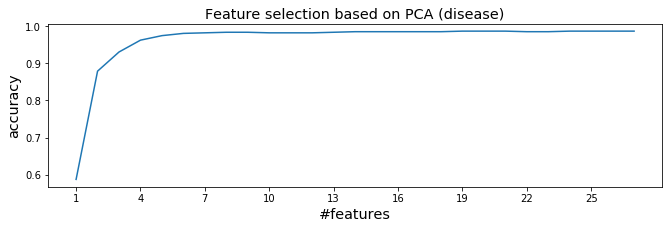

In [94]:
# this takes a while
plot_progressive_pca_validation(gabor_features,
                                disease, 'disease')

Using increasing amounts of principal components for classifying pets. With a small number of features we get better performance than with all features!!

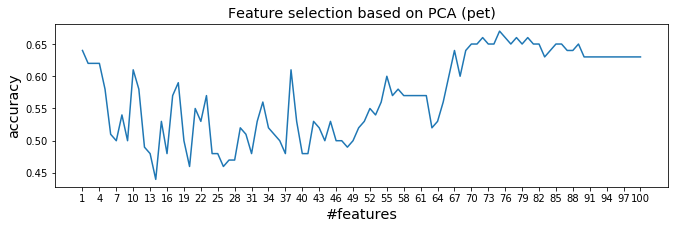

In [251]:
plot_progressive_pca_validation(bovw_features,
                                pet, 'pet',
                                classifier=bovw_cls)

#### Linear Discriminant Analysis

In [96]:
# use PCA for selecting 2 features
pca_feats = decomposition.PCA(n_components=2) \
                .fit_transform(gabor_features)

# use LDA for selecting 2 features
lda_feats = discriminant_analysis.LinearDiscriminantAnalysis() \
                .fit_transform(gabor_features, disease)

In [97]:
def pca_lda_plot(pca_feats, lda_feats, c):
    splot(121);
    scatter(pca_feats[:,0], pca_feats[:,1], c=c);
    util.title('Disease classification with PCA: {:.0f}%'
               .format(100*util.l1o_model_validation(pca_feats, disease)))
    splot(122);
    scatter(lda_feats[:,0], lda_feats[:,1], c=c);
    util.title('Disease classification with LDA: {:.0f}%'
               .format(100*util.l1o_model_validation(lda_feats, disease)))

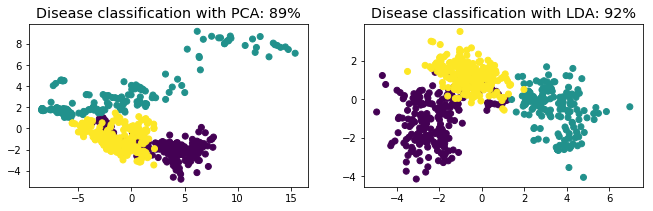

In [98]:
pca_lda_plot(pca_feats, lda_feats, disease)

> Making the features better linearly seperable does not help so much when using a nearest neighbor classifier!

Use a linear SVM to boost performance on LDA features (a bit)

In [99]:
print('PCA+SVM: {:.0f}%\nLDA+SVM: {:.0f}%'.format(
    100*util.l1o_model_validation(pca_feats, disease,
                                  svm.SVC(kernel='linear')),
    100*util.l1o_model_validation(lda_feats, disease,
                                  svm.SVC(kernel='linear'))))

PCA+SVM: 83%
LDA+SVM: 93%


Plus, we see that performance on the PCA-ed feats decreases!

### Convolutional Neural Networks (CNNs)

We have learned in this tutorial what convolution and pooling is. A CNN consists of several more layers for mapping input signals to output classes, providing an end-to-end learning mechanism for both the representation and the classification function.

![convnet](images/convnet.png)

The input layer of a CNN consists of filters that are used to extract features from the input signal by convolution. For images, the learned filters resemble the Gabor filters quite a lot.

![convlayer](images/weights.jpg)

Ok, so now we don't have to put engineering effort in feature extraction, but we have to think about / experiment with:

* number of convolution/pooling/connected layers
* number of filters
* filter size
* narrow vs wide convolution
* stride size
* channels

The following describes one such combination of choices

In [100]:
random.seed(42) 

#### Image classfication with a CNN

The mnist written digits dataset is a common benchmark for image classification and ships with Keras itself:

Using TensorFlow backend.


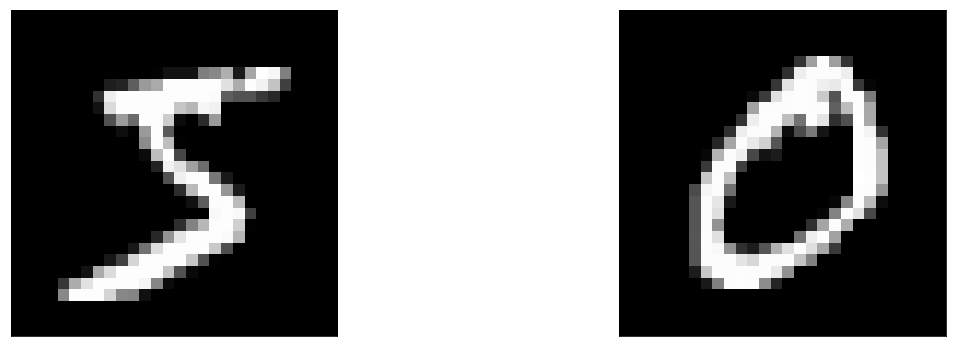

In [101]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
util.image_subplots((squeeze(X_train[0,:,:]),
                     squeeze(X_train[1,:,:])))

In [102]:
from keras.utils.np_utils import to_categorical
from keras import backend as K

height, width = 28, 28
n_classes = 10

# we have to preprocess the data into the right form
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# 4D due to number of channels (=1)
X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

X_train /= 255
X_test /= 255

y_train = to_categorical(y_train.astype('int'), n_classes)
y_test = to_categorical(y_test.astype('int'), n_classes)

X_train = X_train.reshape(X_train.shape[0], height, width, 1)
X_test = X_test.reshape(X_test.shape[0], height, width, 1)

The data is further preprocessed (not shown), and with Keras it is easy to build a CNN:

In [103]:
from keras.models import Sequential
model = Sequential()

In [104]:
input_shape = (28, 28, 1)
n_filters = 32
filter_size = 3
pool_size = 2

We can create a `filter_size * filter_size` convolutional layer as an instance of `Convolution2D`

In [105]:
from keras.layers.convolutional import Convolution2D

conv_layer = Convolution2D(n_filters, filter_size, filter_size,
                           border_mode='valid',
                           input_shape=input_shape)
model.add(conv_layer)

Add activation (do / not send signal to the next layer) and pooling layers:

In [106]:
from keras.layers import Activation
from keras.layers.convolutional import MaxPooling2D

model.add(Activation('relu'))
model.add(Convolution2D(n_filters, filter_size, filter_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

And finally map the convolution and pooling results to the output categories (0-9):

In [107]:
from keras.layers import Flatten, Dense

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

Train the model, using `batch_size` samples per iteration, and observing the whole dataset `nb_epochs` times.

In [108]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=512, nb_epoch=2,
          validation_data=(X_test, y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 86s - loss: 0.3595 - acc: 0.8976 - val_loss: 0.1078 - val_acc: 0.9685

In [109]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9805


### Visual recognition with pretrained deep convnets

There are deep models trained on millions of images and classes, right underneath your fingertips. We can use those to classify images, or to *extract features* and use those for our classification problem.

In [110]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [111]:
# preprocess image for usage in vgg model
def img_pp(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = expand_dims(x, axis=0)
    return preprocess_input(x)

# extract features
def extract_vgg_features(img_pp, vgg_model):
    return vgg_model.predict(img_pp).flatten()

Using the dog/cat images still pointed to by `filepaths`, extract deep features using a pretrained CNN from Keras, with special thanks to Oxford's Visual Geometry Group.

In [112]:
model = VGG16(weights='imagenet', include_top=False)
with mp.Pool(6) as vgg_pool:
    vgg_feats = array([extract_vgg_features(img_pp(filepath),
                                            model)
                       for filepath in filepaths])

Show us the money!

In [113]:
util.l1o_model_validation(vgg_feats, pet)

0.53000000000000003

...what a disappointment!

Recall that we are using the output of the usually one-but-last layer, so we probably have to take one more transformation step. Let's use PCA.

In [114]:
ncs = arange(5)+1
pca_res = []
for nc in ncs:
    pca = decomposition.PCA(n_components=nc)
    pca_res.append(util.l1o_model_validation(vgg_feats,
                                             pet,
                                             normalizer=pca))

With PCA applied to the deep features, we achieve almost perfect performance!

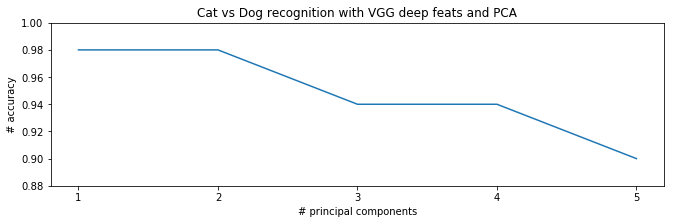

In [115]:
plot(ncs, pca_res);
xlabel('# principal components'); ylabel('# accuracy');
ylim([0.88,1]); xticks(ncs);
title('Cat vs Dog recognition with VGG deep feats and PCA');

(Like, OMG!!##!? WTF????!!&%$! is this real)

In [116]:
pca_vgg_feats = decomposition.PCA(n_components=2).fit_transform(vgg_feats)

### Whooohoooooo!

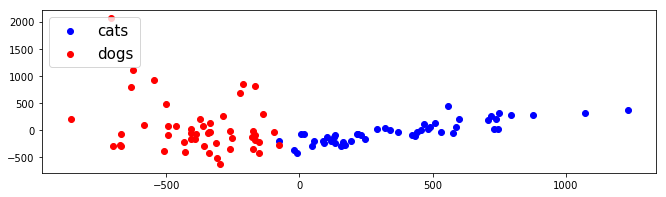

In [117]:
scatter(pca_vgg_feats[labels==0,0],
        pca_vgg_feats[labels==0,1], c='b');
scatter(pca_vgg_feats[labels==1,0],
        pca_vgg_feats[labels==1,1], c='r');
legend(['cats','dogs'], fontsize=15, loc='upper left');

## Speech processing hackathon

Only if there is time left, otherwise just try this at home.

In [118]:
# standard audio sample rate (samples per second)
sample_rate = 44100.

From a couple of speakers we have 2 recordings and associated metadata, so we can build models from speech data to infer that metadata.

In [119]:
from metadata import *

print(list(people.keys()))
people['Ivo']

['Marcel', 'Ivo2', 'Andrew', 'Nelli', 'Gabriele', 'Ivo', 'Jelte', 'Ron']


{'age': 35, 'gender': 'male', 'mood': 'neutral', 'nationality': 'Dutch'}

In [120]:
sentences

{'s1': 'I want to implement a speech recognition system',
 's2': 'the fourier transform is super cool but rather complex'}

I recorded the audio on my mac with quicktime, resulting in m4a files. With ffmpeg you can convert between many audio, image and video formats. For this tutorial I shipped only the wav files.

In [121]:
# point to folder where data is stored
data_folder = 'data/speech_samples/'

def m4a2wav(data_folder):
    m4a_list = [os.path.join(data_folder, file_name)
                for file_name in os.listdir(data_folder)
                if file_name.endswith('m4a')]
    for m4a_file in m4a_list:
        os.system('ffmpeg -y -i {} {}'.\
                  format(m4a_file, m4a_file[:-3]+'wav'))

# convert all m4a files
for person in people.keys():
    m4a2wav(os.path.join(data_folder, person))

IPython provides awesome utilities

In [122]:
from IPython.display import *

# play a wav file
def play_sound(data):
    global sample_rate
    if type(data) == str:
        return Audio(filename=data,
                     autoplay=False, rate=sample_rate)
    else:
        return Audio(data.astype(int16),
                     autoplay=False, rate=sample_rate)
    
play_sound(os.path.join(data_folder, 'Ivo', 's1.wav'))

Load the speech data

In [123]:
from scipy.io import wavfile

# return mono signal and normalize to 1/-1 as most loud/quite
def read_wave(filepath):
    sample_rate, audio_channels = wavfile.read(filepath)
    return audio_channels[:,0] /\
            float(np.max(np.abs(audio_channels[:,0])))
    
s1 = read_wave(os.path.join(data_folder, 'Nelli', 's1.wav'));
s2 = read_wave(os.path.join(data_folder, 'Gabriele', 's1.wav'));

Plot the signals

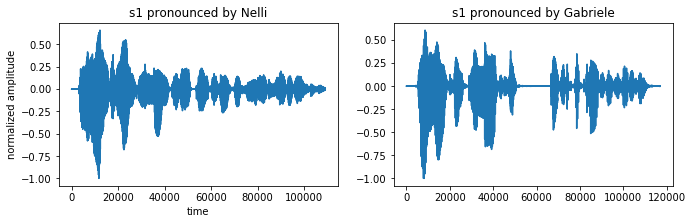

In [124]:
subplot(121); plot(s1); title('s1 pronounced by Nelli');
xlabel('time'); ylabel('normalized amplitude');
subplot(122); plot(s2); title('s1 pronounced by Gabriele');

Extract features using the Fast Fourier Transform

In [125]:
# extract features from a wave with fft (which is just available due to the pylab namespace)
def fourier_transform(w):
    global sample_rate
    freq_bins = fft.rfftfreq(len(w), 1/sample_rate)
    power = absolute(fft.rfft(w))**2 / len(w)
    return power, freq_bins

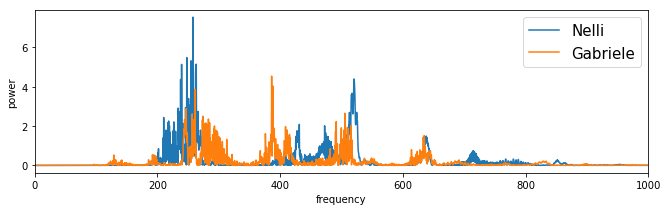

In [126]:
p1, f1 = fourier_transform(s1); p2, f2 = fourier_transform(s2);
plot(f1, p1, label='Nelli'); plot(f2, p2, label='Gabriele');
pyplot.xlim([0, 1000]); pyplot.legend(fontsize=15);
xlabel('frequency'); ylabel('power');

It looks like we can use the frequency distributions to discriminate between Nelli and Gabriele. Let's chop it up for a compact representation.

In [127]:
# extract the amount of power in a given frequency range
def power_at(power, freq, lbound, hbound):
    lbin = argmin(abs(freq - lbound))
    hbin = argmin(abs(freq - hbound))
    # TODO: correct for non-exact localization
    return sum(power[lbin:hbin])

Create a dataset

In [128]:
# dataset params
freq_step = 100
freq_max = 1000
lbounds = arange(0, freq_max, freq_step)

# store features and labels
features = []
labels = []

# keep waves in memory for later usage
waves = []

In [129]:
for person in people.keys():
    for s in sentences.keys():
        w = read_wave(os.path.join(data_folder, person, '{}.wav'\
                                   .format(s)));
        p, f = fourier_transform(w)
        features.append(array([power_at(p, f, b, b+freq_step) 
                               for b in lbounds]))
        labels.append([person,
                       people[person]['nationality'],
                       people[person]['gender'],
                       people[person]['mood'],
                       people[person]['age'],
                       s])
        waves.append(w)

In [130]:
# create dataframe
feature_columns = ['f{}'.format(i) for i in range(len(features[0]))]
label_columns = ['name', 'nationality', 'gender', 'mood', 'age', 'sentence']
dataset = pd.DataFrame(data=concatenate((features, labels), axis=1),
                       columns=concatenate((feature_columns, label_columns)))

# normalize the features
dataset[feature_columns] = preprocessing.StandardScaler() \
                           .fit_transform(dataset[feature_columns])

# also include numeric labels
for label in label_columns:
    dataset['n_{}'.format(label)] = preprocessing.LabelEncoder() \
                                    .fit_transform(dataset[label])

Create dataframe (code not shown)

In [131]:
dataset.head(5).T

0         1          2         3           4
f0            -0.421025 -0.404128   -0.43439 -0.414063   -0.180684
f1            -0.628028 -0.880296   0.704927  0.819942    -0.84289
f2             0.272792 -0.325877  -0.661536 -0.301881    -1.24012
f3            -0.583158 -0.949314    1.89822 -0.490668   -0.330657
f4            -0.932387 -0.898587    2.30568   0.19562   -0.616166
f5            -0.850168 -0.661366    3.16831   0.24307   -0.861628
f6             0.247941 -0.525531   0.648278 -0.244405    -1.36581
f7             0.874248 -0.533401    1.78762   1.67368     -0.9359
f8               2.5395  0.624118  -0.491731  -1.10561   -0.777151
f9              3.39059 -0.301294 -0.0401555  0.528934   -0.627082
name             Marcel    Marcel       Ivo2      Ivo2      Andrew
nationality       Dutch     Dutch      Dutch     Dutch  Australian
gender             male      male       male      male        male
mood            neutral   neutral      angry     angry     neutral
age                  33        33         36        36          40
sentence             s2        s1         s2        s1          s2
n_name                5         5          3         3           0
n_nationality         1         1          1         1           0
n_gender              1         1          1         1           1
n_mood                1         1          0         0           1
n_age                 2         2          4         4           5
n_sentence            1         0          1         0           1

In [132]:
# lazy coloring scheme ;)
colors = cluster.k_means(random.rand(100000,3), len(people))[0]

In [133]:
def lda_plot(features=None):
    global dataset, label_columns, feature_columns, colors
    
    if features is None:
        features = dataset[feature_columns]
    
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
    util.figsize(9, 10)

    for i, label in enumerate(label_columns):
        num_label = 'n_{}'.format(label)
        lda_feats = lda.fit_transform(features,
                                      dataset[num_label])
        subplot(3, 2, i+1)
        if lda_feats.shape[1] == 2:
            x = lda_feats[:,0]
            y = lda_feats[:,1]
        else:
            x = arange(len(lda_feats))
            y = lda_feats

        for j, l in enumerate(unique(dataset[num_label])):
            idx = (dataset[num_label]==l).values
            scatter(x[idx], y[idx], c=colors[j], s=80);

        title(label);
        legend(unique(dataset[label]), loc='best');

    util.figsize()

#### Use LDA for an informative plot

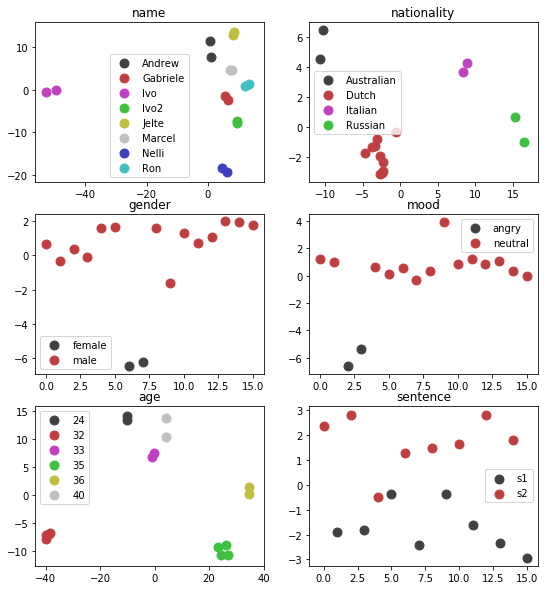

In [134]:
lda_plot()

#### Bag-of-audio-words using n-jet filters

In [135]:
# use a filterbank of gaussian derivatives ('njet') for feature extraction
def apply_filter_bank(signal):
    # use 2 different filter sizes
    stds = array([1e-1, 1e-2]) * 1000
    # use 2 differential orders
    orders = [1,2]
    # store result
    f = []
    params = []
    for s in stds:
        for o in orders:
            f.append(ndimage.gaussian_filter(signal, s, o))
            params.append([s,o])
    return array(f), array(params)

# show the filters by convolving with a spike
spike = zeros(1001); spike[500] = 1;
f_spikes, params = apply_filter_bank(spike)

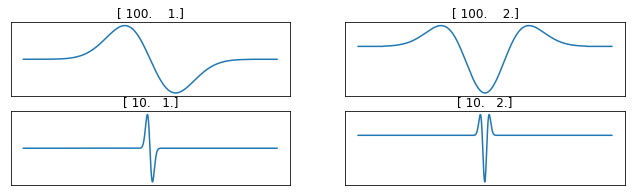

In [136]:
for i, f_spike in enumerate(f_spikes):
    subplot(2, 2, i+1);
    extend = 150*int(params[i,0])
    plot(f_spike[len(f_spike)/2-extend:len(f_spike)/2+extend]);
    xticks([]); yticks([]); title(params[i,:])

In [137]:
# extract 'local features':
# apply the filter bank and summarize the filter output with aggs over regions of size fsize in steps of size step
def extract_local_features(signal,
                           fsize=int(sample_rate/8), step=int(sample_rate/32), aggs=[max],
                           standardize=True):
    f_signal = apply_filter_bank(signal)[0]
    samples = arange(0, len(signal)-fsize/2, step).astype('int')
    feats = zeros((len(samples), f_signal.shape[0]*len(aggs)))
    n_row = 0
    for i in samples:
        n_col = 0
        for agg in aggs:
            for f in f_signal[:, i:i+fsize]:
                feats[n_row, n_col] = agg(f)
                n_col += 1
        n_row += 1
    return preprocessing.StandardScaler().fit_transform(feats) if standardize else feats

Look at an example of local features over time

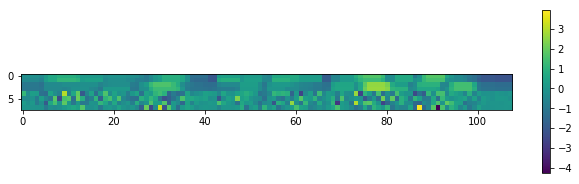

In [138]:
feats = extract_local_features(waves[0], aggs=[max, mean])
imshow(feats.T); colorbar();

In [139]:
# extract all local features
def extract_local_features_wrapper(i):
    global waves
    return extract_local_features(waves[i], standardize=False)

# feature extraction is heavy - hooray to multiprocessing
from multiprocessing import Pool
thread_pool = Pool(6)
all_local_feats = thread_pool.map(extract_local_features_wrapper, range(len(waves)));

# create vocabulary
k = 10
n_feats_per_sample = 50
feats_for_clustering = zeros((n_feats_per_sample*len(waves),
                              all_local_feats[0].shape[1]))

# harvest features for clustering
for i, local_feats in enumerate(all_local_feats):
    feats_for_clustering[i*n_feats_per_sample:(i+1)*n_feats_per_sample,:] = \
                         random.permutation(local_feats)[:n_feats_per_sample]

# train standard scaler
bow_scaler = preprocessing.StandardScaler().fit(feats_for_clustering)
        
# kmeans object for clustering
vocab = cluster.KMeans(n_clusters=k)
vocab.fit(bow_scaler.transform(feats_for_clustering))

# use the vocab for quantizing the local features into a fixed-length representation
bow_feats = zeros((len(waves), k))
for i, local_feats in enumerate(all_local_feats):
    bow_hist, _ = histogram(vocab.predict(bow_scaler.transform(local_feats)), k)
    bow_feats[i,:] = preprocessing.normalize(bow_hist.reshape(1,-1))

Use the LDA plot to illustrate the bow features

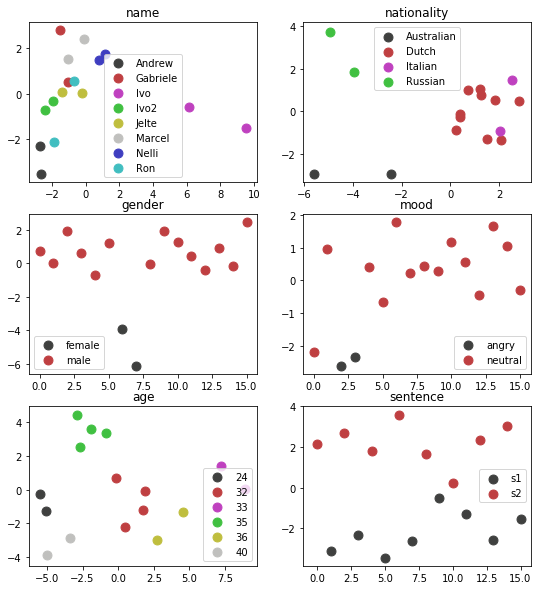

In [141]:
lda_plot(bow_feats)

In [142]:
# using leave-1-out model validation with your favorite classifier and normalizer
def l1o_val(data, labels,
            classifier = neighbors.KNeighborsClassifier(1),
            normalizer = preprocessing.StandardScaler()):
    if isinstance(data, pd.DataFrame):
        data = data.values.astype('float')
    l1o = cross_validation.LeaveOneOut(data.shape[0])
    predictions = np.zeros(labels.shape, dtype=labels.dtype)
    for train_idx, test_idx in l1o:
        if isinstance(normalizer, discriminant_analysis.LinearDiscriminantAnalysis):
            train_data = normalizer.fit_transform(data[train_idx], labels[train_idx])
        else:
            train_data = normalizer.fit_transform(data[train_idx])
        classifier.fit(train_data, labels[train_idx])
        predictions[test_idx] = classifier.predict(normalizer.transform(data[test_idx]))
    return sum(predictions == labels) / float(data.shape[0])

def fft_bow_cls_wrapper():
    pca = decomposition.PCA(n_components=6)
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=6)
    for label in label_columns:
        labels = dataset['n_{}'.format(label)]
        fft_res = l1o_val(dataset[feature_columns], labels)
        bow_res = l1o_val(bow_feats, labels)
        fft_res_pca = l1o_val(dataset[feature_columns], labels, normalizer=pca)
        bow_res_pca = l1o_val(bow_feats, labels, normalizer=pca)
        fft_res_lda = l1o_val(dataset[feature_columns], labels, normalizer=lda)
        bow_res_lda = l1o_val(bow_feats, labels, normalizer=lda)
        print('***', label, '***')
        print('fft: {:.2f}/{:.2f}/{:.2f}, bow: {:.2f}/{:.2f}/{:.2f}\n'\
              .format(fft_res, fft_res_pca, fft_res_lda, bow_res, bow_res_pca, bow_res_lda))

Do a round of classification on fft and bow features, with the raw/pca/lda version.

In [143]:
fft_bow_cls_wrapper()

*** name ***
fft: 0.38/0.31/0.38, bow: 0.12/0.12/0.12

*** nationality ***
fft: 0.81/0.81/0.62, bow: 0.44/0.50/0.31

*** gender ***
fft: 0.94/0.94/0.88, bow: 0.75/0.75/0.62

*** mood ***
fft: 0.75/0.69/0.69, bow: 0.62/0.69/0.62

*** age ***
fft: 0.44/0.38/0.44, bow: 0.12/0.12/0.19

*** sentence ***
fft: 0.56/0.56/0.56, bow: 0.69/0.88/0.62



> On these data, fft based features seem to perform well

#### Convolutional neural networks

A CNN can also be trained on 1D signals such as speech. Here, it does not make much sense due the small amount of data, but if you have larger amounts I suggest you use this.

In the following, we'll build a 1D CNN for discriminating between the 2 sentences.

In [144]:
# lets try to do similar stuff with a convnet
from keras.layers.convolutional import Convolution1D
from keras.layers import Dropout

# use fixed length waves
max_duration = max([len(w) for w in waves])
pwaves = array([concatenate((w, zeros((max_duration-len(w),)))) for w in waves])
pwaves = pwaves.reshape(pwaves.shape + (1,))
pwaves.shape

keras_labels = to_categorical(dataset['n_sentence'].astype('int'), 2)

# build the model for classifying into 2 classes (sentence 1 and sentence 2)
num_filters = 2
filter_size = 100
model = Sequential()
model.add(Convolution1D(num_filters, filter_size, input_dim=1, input_length=max_duration))
model.add(Flatten())
model.add(Dense(2)) # s1/s2
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

After preprocessing the data (not shown) we can train the model

In [154]:
# fit the model using train- and validation- data
model.fit(pwaves[:8], keras_labels[:8],
          batch_size=4,
          nb_epoch=5,
          validation_data=(pwaves[8:12], keras_labels[8:12]));

Train on 8 samples, validate on 4 samples
Epoch 1/5
8/8 [==============================] - 1s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.9573 - val_acc: 0.5000
Epoch 2/5
8/8 [==============================] - 1s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.9898 - val_acc: 0.5000
Epoch 3/5
8/8 [==============================] - 1s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 5.0168 - val_acc: 0.5000
Epoch 4/5
8/8 [==============================] - 1s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 5.0393 - val_acc: 0.5000
Epoch 5/5
8/8 [==============================] - 1s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 5.0579 - val_acc: 0.5000


Maybe we can do any good after all.

In [155]:
res = model.evaluate(pwaves[12:], keras_labels[12:], verbose=0)
print('Accuracy = {}'.format(res[1]))

Accuracy = 0.5


Not really, but that's ok

We can visualize the filters that have been learned. We set the number of filters to 2 and the filter size to 100 samples.

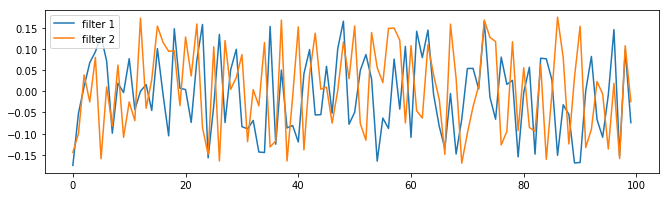

In [147]:
filters = model.layers[0].get_weights()
for i, f in enumerate(filters[0].reshape(filter_size, num_filters).T):
    plot(f, label='filter {}'.format(i+1))
legend();

And we can see that a 100-sample snippet of a wave sort of  resembles the filters:

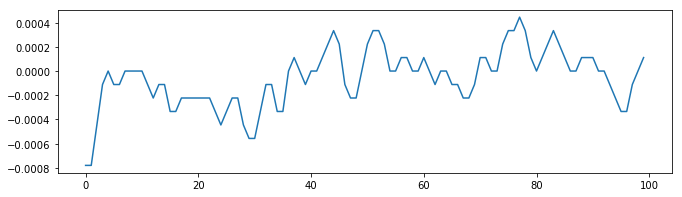

In [148]:
plot(pwaves[0][900:1000]);

## Recap

- Convolution
- Fourier analysis

### Feature engineering
- 1D signals: filter banks, pooling
- 2D signals: bag-of-words

### Feature learning
- PCA / LDA
- Convolutional neural network: cat/dog to perfection
    
### Speech processing hackathon
- Speaker / gender / age / nationality recognition...
- ...based on Fourier / bag-of-words / convnet

Thank you and have a great time at PyData.

ivoeverts@godatadriven.com